In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import subprocess

# Load galaxy image

In [2]:
from galmex.Utils_module import open_fits_image
galaxy_image, header = open_fits_image('example_galaxy.fits')
        

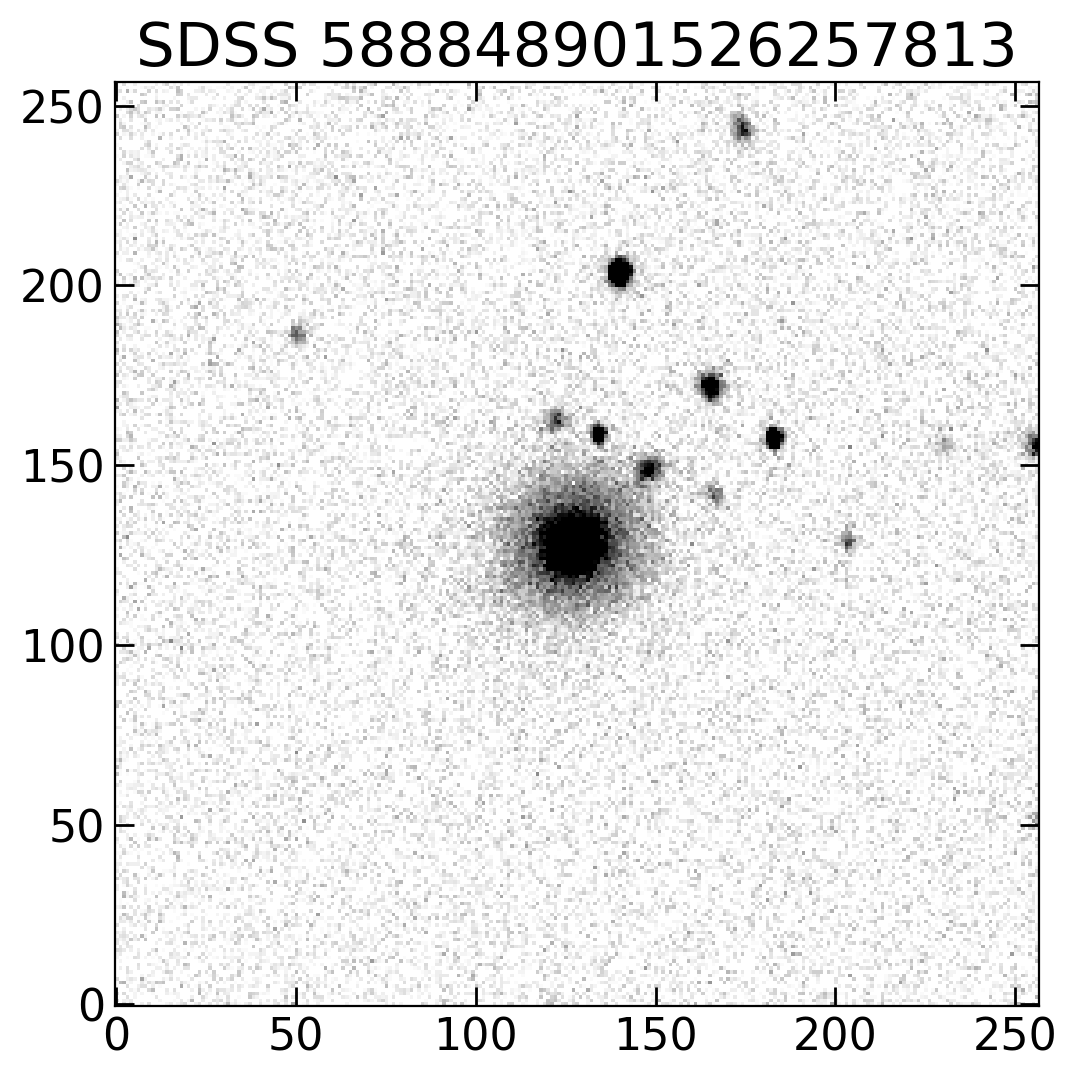

In [3]:
plt.figure(figsize = (6,6), dpi = 200)
plt.subplot(111)
plt.title("SDSS 588848901526257813", fontsize = 22)
m, s = np.nanmedian(galaxy_image), np.nanstd(galaxy_image)
plt.imshow(galaxy_image, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)
#plt.savefig('output_images/Example_galaxy.pdf', bbox_inches = 'tight')

# Estimate and subtract background

## Start BackgroundEstimator class

This function receives only an identifier (galaxy_name) and the galaxy image. All the function built in this class returns 4 objects, respectively: median and standard deviation of the background, the bkg_image, and the image after subtracting the background estimated.   

In [4]:
from galmex.Background_module import BackgroundEstimator
galaxy_name = '588848901526257813'
bkg_estimator = BackgroundEstimator(galaxy_name, galaxy_image)
        

## Flat background
In this option, you can provide the especific value and standard deviation to subtract from the galaxy image. For instance, in the case of SDSS the background is somewhat flat, with median value ~1100 counts, and standard deviation ~6.

In [5]:
bkg_median_flat, bkg_std_flat, bkg_image_flat, galaxy_nobkg_flat = bkg_estimator.flat_background(value = 1100, std = 6)

## Frame background
This option sets a frame around image edges to select pixels and perform a statistic analysis of the background. The image_fraction variable defines the percentage relative to the image size to use as frame. By setting sigma_clipping = True, it is also possible to perform a sigma clipping to avoid contamination from secondary objects within the frame selected pixels. The clipping_threshold variable defines the threshold to discard pixels. For example, clipping_threshold = 3 (with sigma_clipping = True) will discard pixels above median+3sigma before computing background median and standard deviation in selected pixels. 

In [6]:
bkg_median_frame, bkg_std_frame, bkg_image_frame, galaxy_nobkg_frame = bkg_estimator.frame_background(image_fraction = 0.1, sigma_clipping = True, clipping_threshold = 3)

## Source Extractor in Python (SEP)
The SEP package provides a similar implementation of the famous Source EXtractor (SExtractor) code in python. This method is simply a wrapper of the sep.background function. Besides the usual bw, bh, fw and fh, this function can receive additional keywords, as described in https://sep.readthedocs.io/en/v1.0.x/api/sep.Background.html.

In [7]:
bkg_median_sep, bkg_std_sep, bkg_image_sep, galaxy_nobkg_sep = bkg_estimator.sep_background(bw = 100, bh = 100, fw = 3, fh = 3)

## Load from file
If you already have the background fits image (from a SExtractor run, for instance), it is possible to use it as input providing the right path and file names. Just to exemplify all possible uses, I define below some dummy variables. If bkg_file is not provided, it assumes that the bkg file name follow the structure: {bkg_image_prefix}galaxy_name{bkg_image_sufix}.fits. Note that I also assume that it is a fits image.

In [8]:
bkg_file = "background.fits"
bkg_image_path = "./"
bkg_image_prefix = ""
bkg_image_sufix = ""
bkg_image_HDU = 0
bkg_median_load, bkg_std_load, bkg_image_load, galaxy_nobkg_load = bkg_estimator.load_background(bkg_file, bkg_image_path, bkg_image_prefix, bkg_image_sufix, bkg_image_HDU)

## Plot comparisons

For obvious reasos, I will not include the plot for the flat estimate.

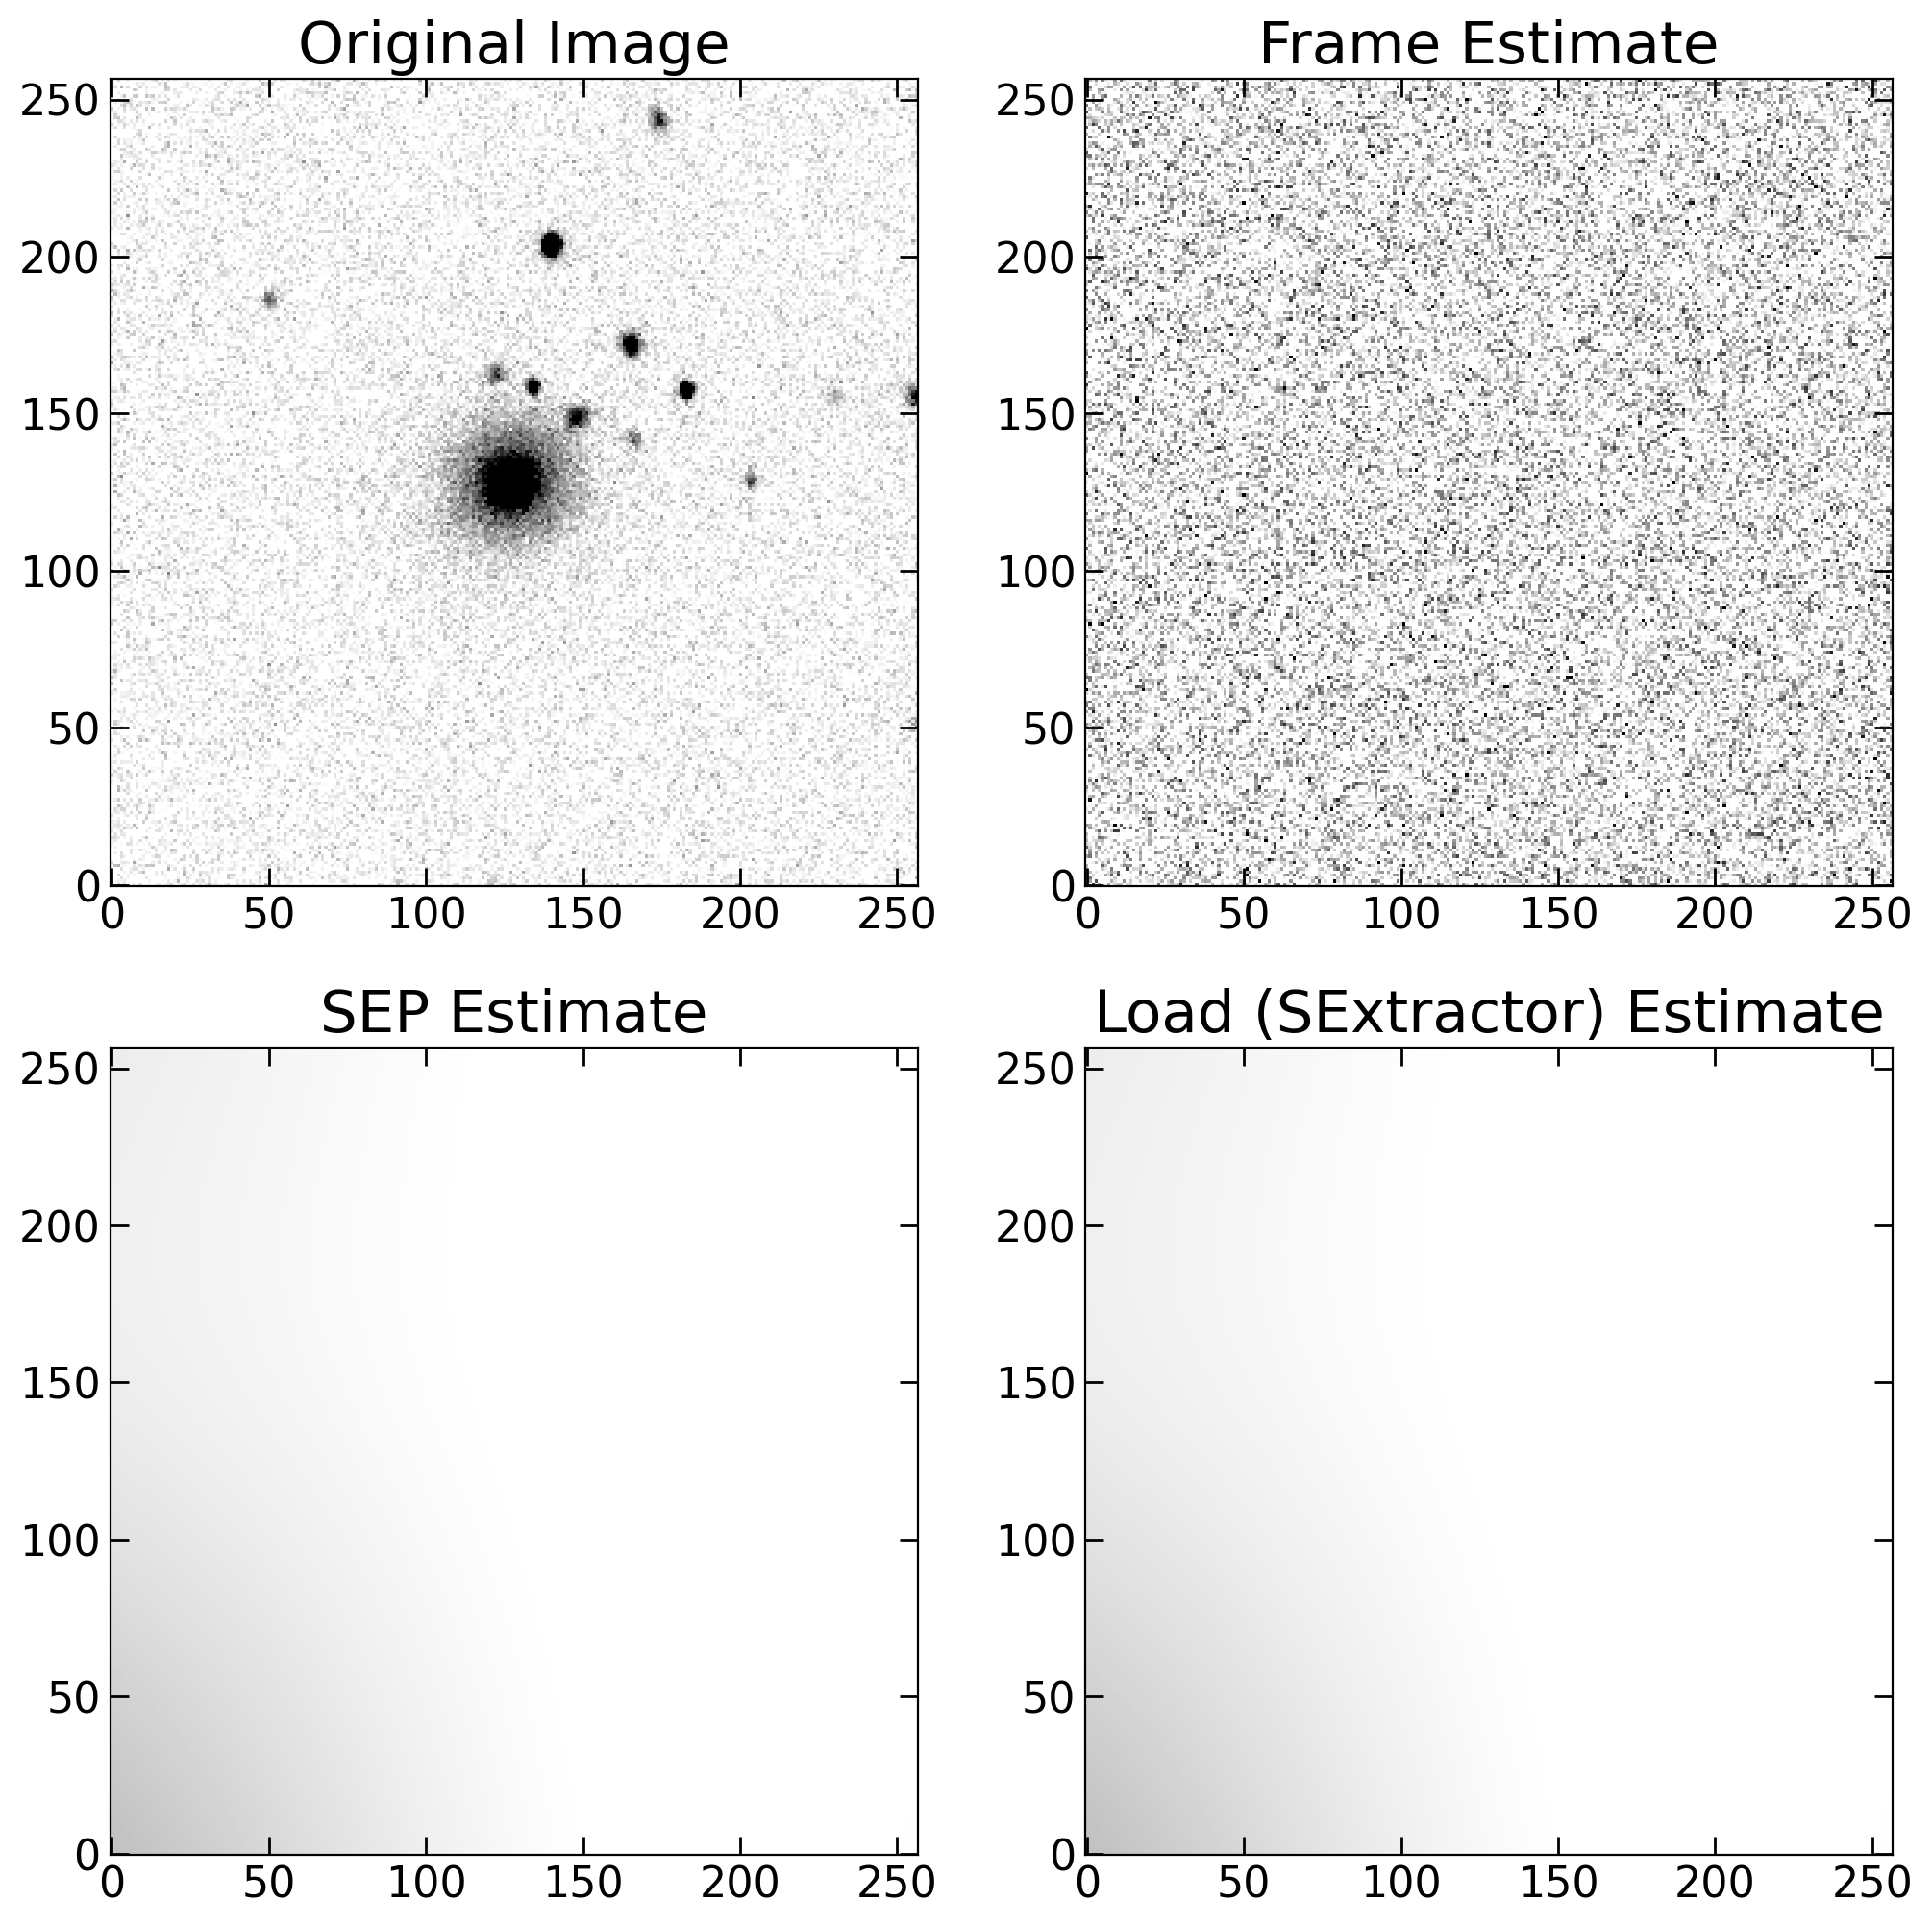

In [9]:
plt.figure(figsize = (12,12), dpi = 200)


plt.subplot(2,2,1)
plt.title("Original Image", fontsize = 22)
m, s = np.nanmedian(galaxy_image), np.nanstd(galaxy_image)
plt.imshow(galaxy_image, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,2)
plt.title("Frame Estimate", fontsize = 22)
m,  s = np.nanmedian(bkg_image_frame), np.nanstd(bkg_image_frame)
plt.imshow(bkg_image_frame, origin = 'lower', cmap = 'gray_r', vmin = m, vmax = m+(3*s))
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.subplot(2,2,3)
plt.title("SEP Estimate", fontsize = 22)
m,  s = np.nanmedian(bkg_image_sep), np.nanstd(bkg_image_sep)
plt.imshow(bkg_image_sep, origin = 'lower', cmap = 'gray_r', vmin = 1132, vmax = 1134)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16);

plt.subplot(2,2,4)
plt.title("Load (SExtractor) Estimate", fontsize = 22)
m,  s = np.nanmedian(bkg_image_load), np.nanstd(bkg_image_load)
plt.imshow(bkg_image_load, origin = 'lower', cmap = 'gray_r', vmin = 1132, vmax = 1134)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                 color = 'k', width = 1)
#plt.savefig('output_images/bkg_comparison.pdf', bbox_inches = 'tight')

# Detect Objects in the Image
There are two main ways to detect objects within this package (at least, for now). First is the commonly used SExtractor. Second is using the SExtractor python alias, SEP. Regarding processing time, the second is faster, due to being already python implemented and not involving reading, write, os operations. Therefore, if you feel that SEP is doing a good job, would recommend using it.

## Import Detector Class

Just like the background estimator class, the detector receives the object identification (galaxy_name) and the image. In the following example I will be very permissive with the detection threshold, in order to guarantee that no galaxy pixel is lost in the segmentation map, which can be relevant to the final segmentation map

In [10]:
from galmex.Detection_module import ObjectDetector
        

## SExtractor detection
Running SExtractor for a large dataset can be though sometimes. I included a simple, automated SExtractor runner in the code, such that it can be easily called via Python. Also, it can be included in for loops effortlessly. A caveat, however, is that I'm assuming that all sextractor-related files (.sex, .param, .conv, etc...) are within the same folder (sex_folder) as the default file (default.sex). If needed to use files from different folders, please change directly on the default.sex file. Furthermore, to iteratively provide sextractor keywords, I included the "sex_keywords" variable, which must a be dictionary with the variable name (exactly like in the SExtractor default.sex file) and the desired value. See below for an example of sex_keywords and function call. Since I also include the "SEP" option, I normalize the output catalog to have similar columns in both cases (x, y, a, b, theta, etc...).  

In [11]:
detector = ObjectDetector(galaxy_name, galaxy_image) ## Here I'm using the non-background subtraction just to highlight that the Sextractor itself makes a bkg removal (but it can be turned off in default.sex)

sex_keywords = {"DETECT_MINAREA": 10,
                "DETECT_THRESH": 1,
                "VERBOSE_TYPE": "QUIET"}
sex_catalog, sex_segmentation = detector.sex_detector(sex_folder = './sextractor_files/', 
                                                      sex_default = 'default.sex', 
                                                      sex_keywords = sex_keywords, 
                                                      sex_output_folder = './', clean_up = True)

## SEP detection

Similar to background estimation, I included a built in function to detect objects using SEP.extract function. More details available in https://sep.readthedocs.io/en/v1.0.x/api/sep.extract.html. Also, the sep.extract expects an image with background already subtracted (which is not the case for SExtractor). If sub_bkg = False, it means that the image provided in "ObjectDetector" is already background subtracted. If set to True, it will subtract the background within the function, i.e. the image provided is not background subtracted. By definition (hard coded) it will also generate a segmentation map, similar to SExtractor.

In [12]:
detector = ObjectDetector(galaxy_name, galaxy_nobkg_sep) # here I'm using sep bkg subtracted image for consistency
sep_catalog, sep_segmentation = detector.sep_detector(thresh = 1, minarea = 10, deblend_nthresh = 32, 
                                                      deblend_cont = 0.005, filter_type = 'matched',
                                                      bkg_std = bkg_std_frame, sub_bkg = False)

## Results comparison
Below I show a comparison between detected object and segmentation map for sextractor and SEP.

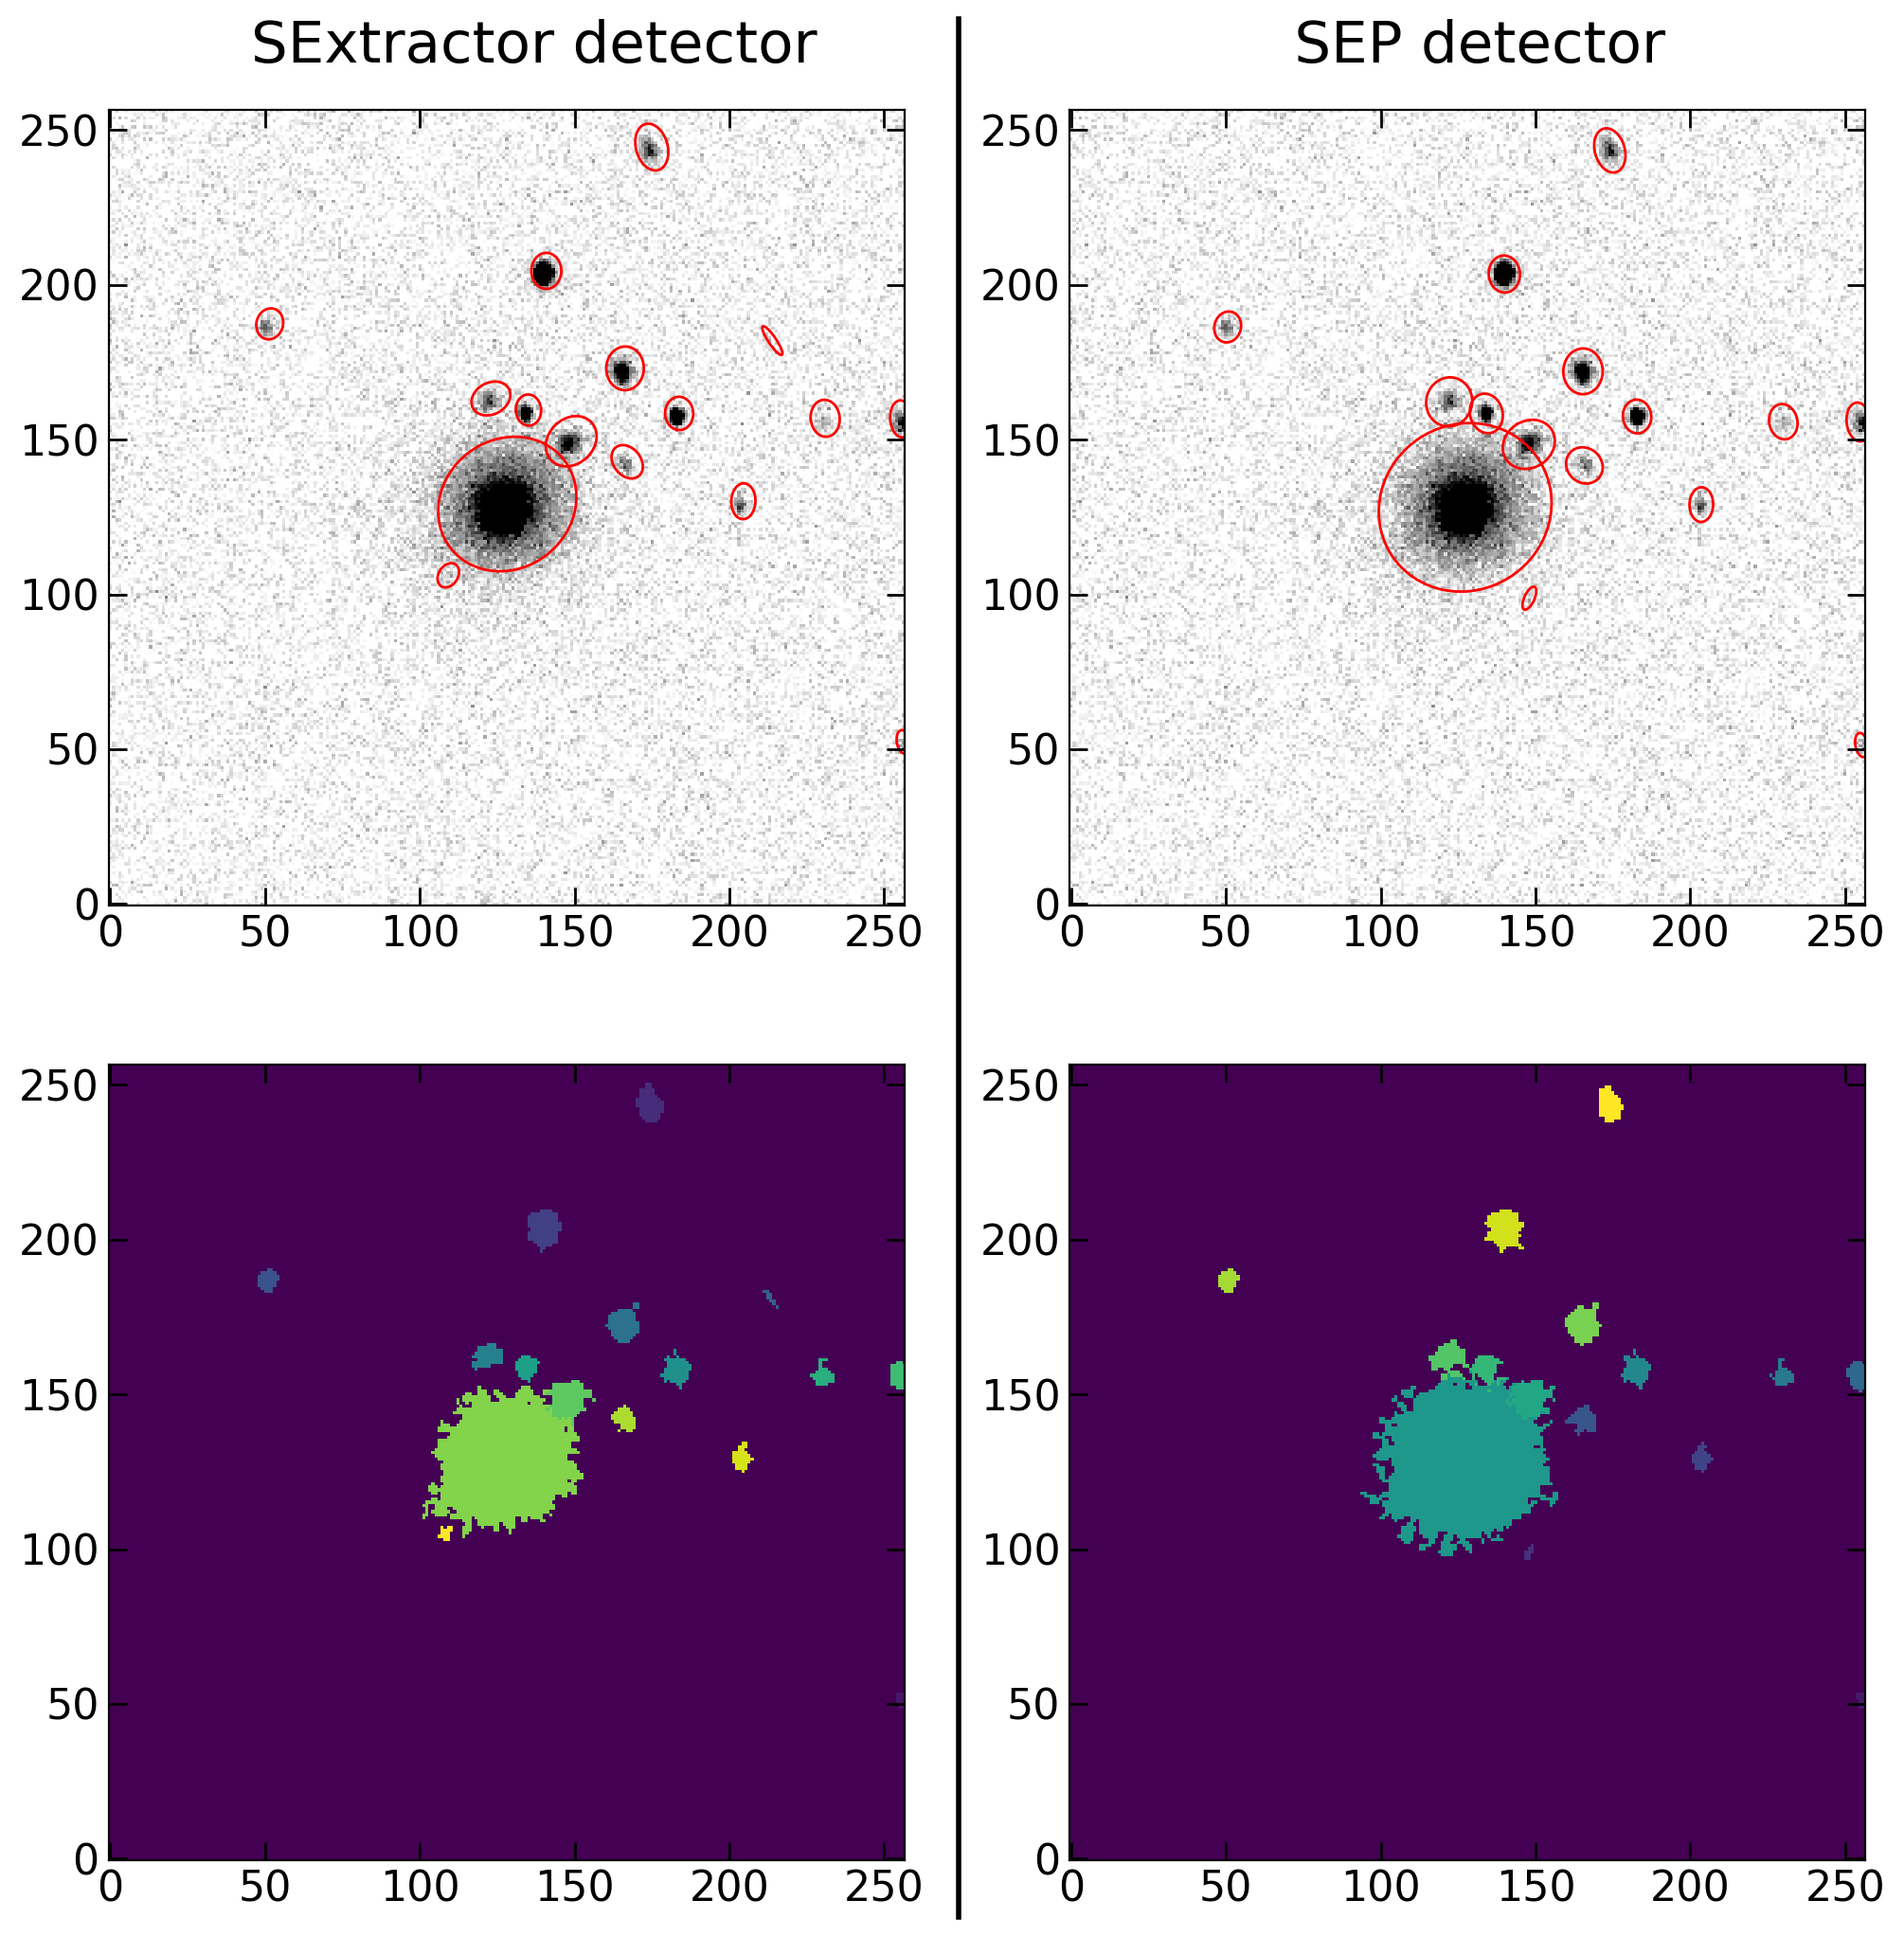

In [13]:
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
fig = plt.figure(figsize = (12,12), dpi = 200)

plt.suptitle("SExtractor detector                          SEP detector", fontsize = 22, y = 0.92)

ax = plt.subplot(2,2,1)
#plt.title('objects properties', fontsize = 22)
m, s = np.nanmedian(galaxy_nobkg_frame), np.nanstd(galaxy_nobkg_frame)
plt.imshow(galaxy_nobkg_frame, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
for i in range(len(sex_catalog)):
    e = Ellipse(xy=(sex_catalog['x'][i], sex_catalog['y'][i]),
                width=6*sex_catalog['a'][i],
                height=6*sex_catalog['b'][i],
                angle=sex_catalog['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)



plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)


ax = plt.subplot(2,2,2)
m, s = np.nanmedian(galaxy_nobkg_frame), np.nanstd(galaxy_nobkg_frame)
plt.imshow(galaxy_nobkg_frame, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
for i in range(len(sep_catalog)):
    e = Ellipse(xy=(sep_catalog['x'][i], sep_catalog['y'][i]),
                width=6*sep_catalog['a'][i],
                height=6*sep_catalog['b'][i],
                angle=sep_catalog['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)



plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)


plt.subplot(2,2,3)
plt.imshow(sex_segmentation, origin = 'lower', cmap = 'viridis')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,4)
plt.imshow(sep_segmentation, origin = 'lower', cmap = 'viridis')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

fig.add_artist(Line2D([0.5, 0.5], [0.085, 0.92], color='black', lw=2, transform=fig.transFigure))


#plt.savefig('detection_comparison.png', bbox_inches = 'tight')

# Clean image from secondary objects



In [14]:
from galmex.Cleaning_module import GalaxyCleaner
cleaner = GalaxyCleaner(galaxy_nobkg_frame, sep_segmentation)

## Fill with constant value

In [15]:
galaxy_clean_flat = cleaner.flat_filler(median = 0)

## Replace bad pixels with background gaussian sampling

In [16]:
mean = np.nanmean(galaxy_nobkg_frame[sep_segmentation == 0])
std = np.nanstd(galaxy_nobkg_frame[sep_segmentation == 0])
galaxy_clean_gauss = cleaner.gaussian_filler(mean, std)

## Sampling from elliptical isophotes following the main object

In [17]:
x, y = len(sep_segmentation)//2, len(sep_segmentation[0])//2
main_id = sep_segmentation[y,x]
galaxy_clean_iso = cleaner.isophotes_filler(sep_catalog['theta'][main_id - 1])

## Comparison between different methods

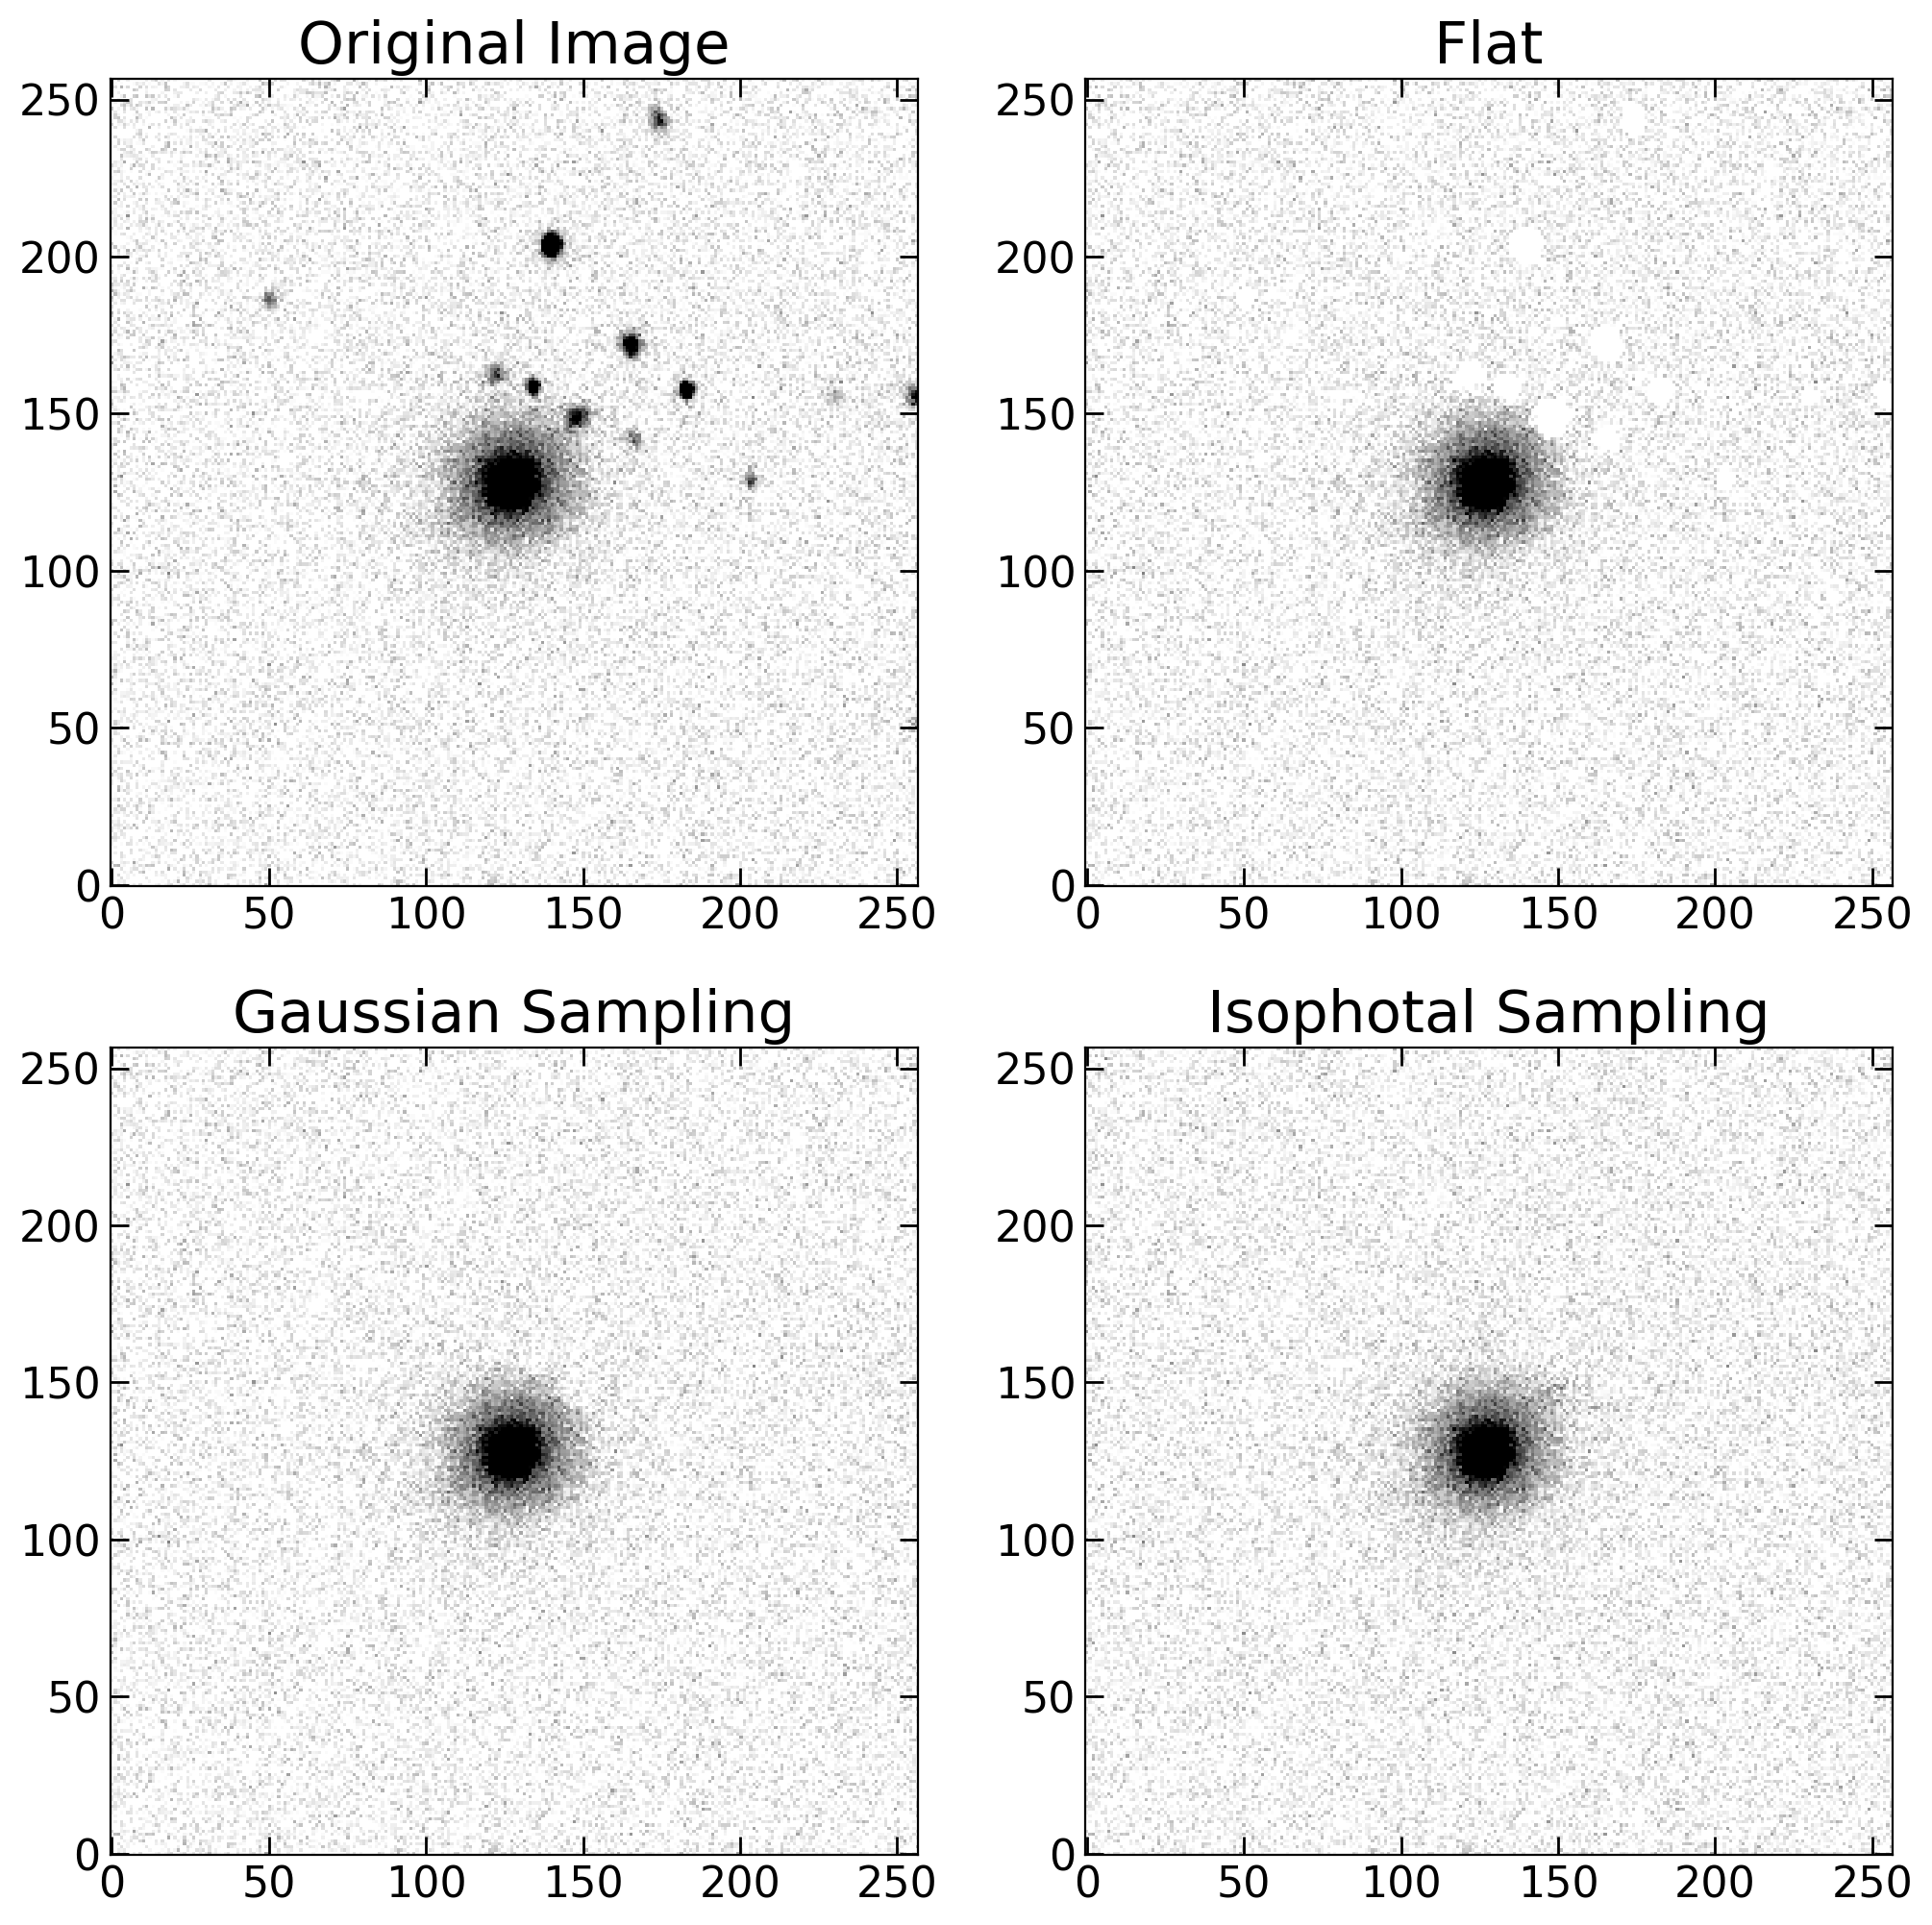

In [18]:
plt.figure(figsize = (12,12), dpi = 200)

ax = plt.subplot(2,2,1)
plt.title('Original Image', fontsize = 22)
m, s = np.nanmedian(galaxy_nobkg_frame), np.nanstd(galaxy_nobkg_frame)
plt.imshow(galaxy_nobkg_frame, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)


plt.subplot(2,2,2)
plt.title('Flat', fontsize = 22)
plt.imshow(galaxy_clean_flat, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)


plt.subplot(2,2,3)
plt.title('Gaussian Sampling', fontsize = 22)
plt.imshow(galaxy_clean_gauss, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,4)
plt.title('Isophotal Sampling', fontsize = 22)
plt.imshow(galaxy_clean_iso, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)
#plt.savefig('output_images/cleaning_comparison.pdf', bbox_inches = 'tight')

# Perform light profile analysis

When analysing galaxies, an important feature is the Petrosian radius, which provides a redshift-independent scale with respect to galaxy light profile. I included within the package a function to easily calculate the Petrosian radius, in pixels. Notably, the Petrosian radius is a more stable choice over other radii adopted in the literature, such as Kron radius, or the radius encomprising a fraction of total flux. Differently from the previous functions, where the input of the main class was simply the image and the segmentation mask, in this case the PetrosianCalculator class is initialized using the desired image (I suggest using a cleaned image) and the properties of the object within the image, i.e. the x and y coordinates (in pixels), semi-major and semi-minor axis (a and b), and the object inclination angle (theta, in radians).

In [19]:
from galmex.Petrosian_module import PetrosianCalculator

x, y, a, b, theta, npix = sep_catalog.iloc[main_id - 1][['x', 'y', 'a', 'b', 'theta', 'npix']]
rp_calc = PetrosianCalculator(galaxy_clean_iso, x, y, a, b, theta)

## Calculate Petrosian Radius - Optimized
Notably, the easiest way to define the Petrosian radius is to calculate using apertures until image edges. However, this becomes extremely slow when dealing with large images. To avoid this, I include in the function below the option to optimize this calculation. Namely, it uses the bissection method to define when it should stop.

In [20]:
eta, growth_curve, radius, rp, eta_flag = rp_calc.calculate_petrosian_radius(rp_thresh = 0.2, 
                                                                 aperture = "elliptical", 
                                                                 optimize_rp = True,
                                                                 interpolate_order = 3, 
                                                                 Naround = 3, rp_step = 0.05)

## Petrosian Radius - Full image analysis
The full analysis can be done simply by altering the "optimize_rp" parameter to false. See how longer it takes in comparison to the previous case.

In [21]:
eta2, growth_curve2, radius2, rp2, eta_flag2 = rp_calc.calculate_petrosian_radius(rp_thresh = 0.2, 
                                                                 aperture = "elliptical", 
                                                                 optimize_rp = False,
                                                                 interpolate_order = 3, 
                                                                 Naround = 3, rp_step = 0.05)

## Petrosian Radius - Circular Apertures
The estimate of Petrosian radius can also be affected by the aperture format. For instance, in the SDSS, they use circular apertures. Despite I think elliptical apertures make more sense with the shapes and light distribution of galaxies, below I show an example using circular apertures.

In [22]:
eta3, growth_curve3, radius3, rp3, eta_flag = rp_calc.calculate_petrosian_radius(rp_thresh = 0.2, 
                                                                     aperture = "circular", 
                                                                     optimize_rp = False,
                                                                     interpolate_order = 3, 
                                                                     Naround = 3, rp_step = 0.05)

## Compute the Kron Radius

The **Kron radius** provides a light-weighted characteristic scale for the galaxy. It is computed as the flux-weighted average elliptical distance of pixels from the galaxy center:


$R_{\text{kron}} = \frac{\sum_i I_i \cdot r_i}{\sum_i I_i}$

where $ I_i $ is the intensity of pixel $ i $, and $ r_i $ is its elliptical distance from the center, expressed in **pixels**.

The method automatically masks out pixels beyond a defined maximum elliptical radius (`rmax`, defaulting to $8 \times a$).


In [23]:
r_kron = rp_calc.get_kron_radius()
print(r_kron)

16.043994758084704


In [24]:
r50, flux_curve, sma_vals = rp_calc.calculate_fractional_radius(fraction=0.5)
print(r50)

12.016735067203012


## Comparison between different setups

Below I show a comparison between the different setups. Since the selected object is very close to a circle, i.e. a/b~1, there is not much difference between Circular or Elliptical apertures.

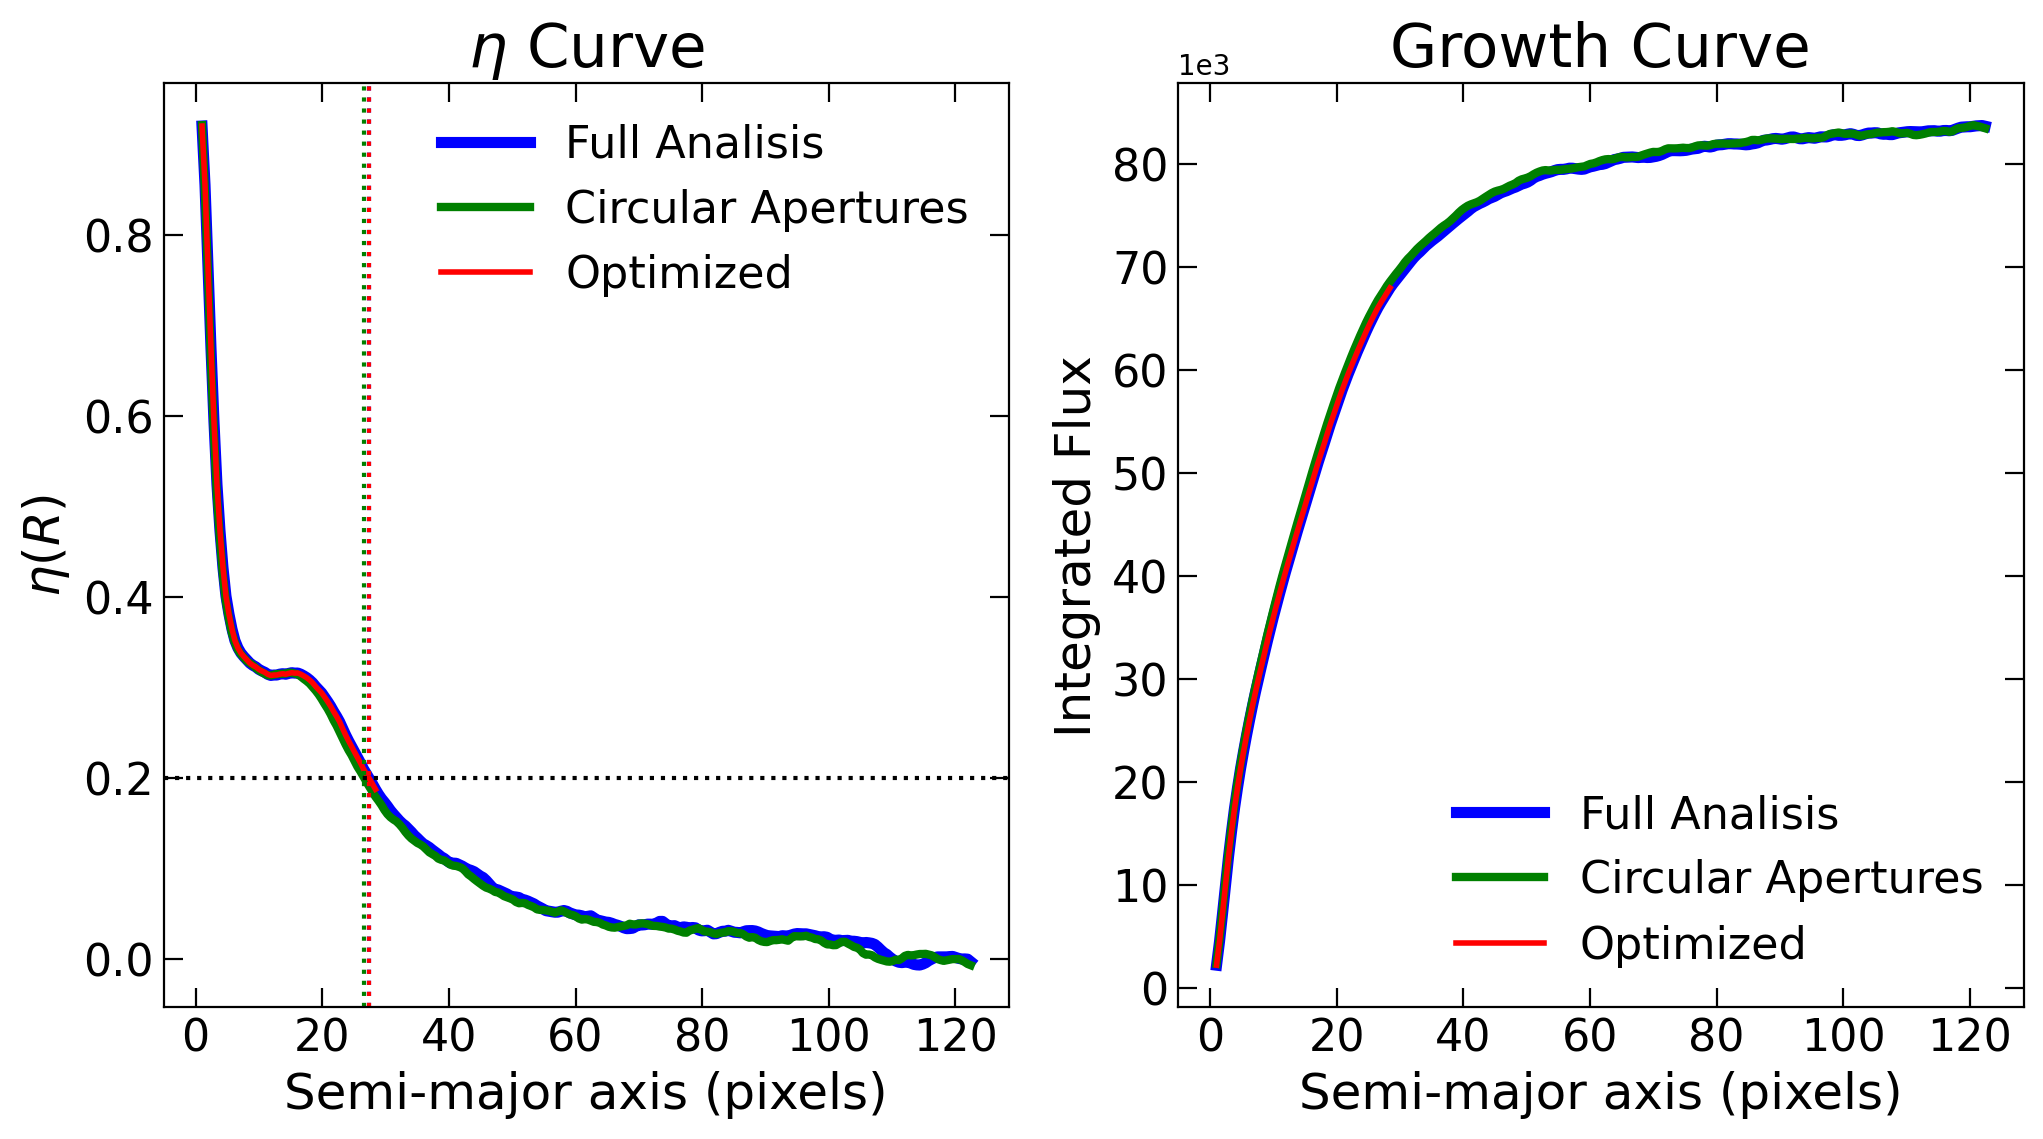

In [25]:
plt.figure(figsize = (12,6), dpi = 200)

plt.subplot(1,2,1)
plt.title(r'$\eta$ Curve', fontsize = 22)
plt.plot(radius2, eta2, color = 'b', lw = 4, label = 'Full Analisis')
plt.plot(radius3, eta3, color = 'g', lw = 3, label = 'Circular Apertures')
plt.plot(radius, eta, color = 'r', lw = 2, label = 'Optimized')
plt.axhline(0.2, color = 'k', ls = ':')
plt.axvline(rp2, color = 'b', ls = ':')
plt.axvline(rp3, color = 'g', ls = ':')
plt.axvline(rp, color = 'r', ls = ':')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Semi-major axis (pixels)", fontsize =  18)
plt.ylabel(r"$\eta(R)$", fontsize = 18)
plt.legend(frameon = False, fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True)

ax = plt.subplot(1,2,2)
plt.title(r'Growth Curve', fontsize = 22)
plt.plot(radius2, growth_curve2, color = 'b', lw = 4, label = 'Full Analisis')
plt.plot(radius3, growth_curve3, color = 'g', lw = 3, label = 'Circular Apertures')
plt.plot(radius, growth_curve, color = 'r', lw = 2, label = 'Optimized')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("Semi-major axis (pixels)", fontsize =  18)
plt.ylabel(r"Integrated Flux", fontsize = 18)
plt.legend(frameon = False, fontsize = 16)
ax.ticklabel_format(axis = 'y', scilimits = (3,3))
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True)
#plt.savefig("output_images/petrosian_comparison.pdf", bbox_inches = 'tight')

# Create segmentation mask

Defining what pixels belong to a given galaxy can directly influence the non-parametric index estimate. Therefore, extra caution is needed in this step, in order to guarantee robust and consistent metrics measurements. For instance, using the sextractor/sep segmentation mask can be extremely influenced by the galaxy redshift, therefore not sampling the same "amount" of the galaxy for different redshifts. Similar to the Petrosian radius calculator, the segmentation relies on more than simply the image and segmentation mask. The inclusion of a characteristic radius (rp, in this case), the x and y positions, and the ellipse defining parameters (a, b, theta) is done to ensure a smoother run in the wrapper code (see pdf manual). 

In [26]:
from galmex.Segmentation_module import SegmentImage
segm = SegmentImage(galaxy_clean_iso, sep_segmentation, rp, x, y, a, b, theta)


## Segmentation from SEP/SExtractor

The simplest, although highly not recommended, way to define the segmentation mask is to use the output of the SEP/SExtractor. I therefore include a function to simply remove other objects and assign the value "1" to the "main" object.

In [27]:
segmentation_original = segm.get_original()

## Limiting to an ellipse with characteristic radius
A robust, and simple, way to define pixels belonging to the galaxy is to use all the pixels within an ellipse with the semi-major axis equals to a characteristic radius, while keeping the same a/b ratio and inclination angle. In the example below, I'm using a factor (k_segmentation) times the petrosian radius.

In [28]:
segmentation_ellipse = segm.limit_to_ellipse(k_segmentation = 1)

## Limiting to the average intensity at a given radius
A more refined, perhaps concise, of defining which pixels belong to the galaxy consists in, instead of limiting to a given radius, limiting to a given intensity/flux. For instance, A proper way to define the threshold intensity/flux is to get the average flux at a given radius. Again, the k_segmentation parameter is a factor that multiplies rp to get the average intensity at k_segmentation times rp, i.e. <I(k_segmentation * rp)>. To avoid including disperse pixels that lie above the threshold, I only perform the selection criteria in pixels attributed to the main object in the SEP/SExtractor segmentation mask. Thus, if the segmented mask when limiting to the average density at a given radius is more permissive than the criteria adopted in SEP/SExtractor for object detection, then the result may be the SEP/SExtractor mask itself.   

In [29]:
segmentation_intensity, mup = segm.limit_to_intensity(k_segmentation = 1)

## Calculate flux and area
In order to calculate the average intensity, I have built functions to return the flux and area at a given radius, as shown below.


In [30]:
flux, area = segm.calculate_flux_and_area(x, y, a, b, theta, scale = 1 * rp)
print(flux/area)

30.10331686767051


## Get average intensity
The threshold value to select pixels uses the function shown below. I'm including it here for completeness, as it may be useful also in standalone uses.

In [31]:
mu_thresh = segm.average_intensity(k_segmentation = 1)
print(mu_thresh)

6.27807587475787


## Segmentation mask comparison

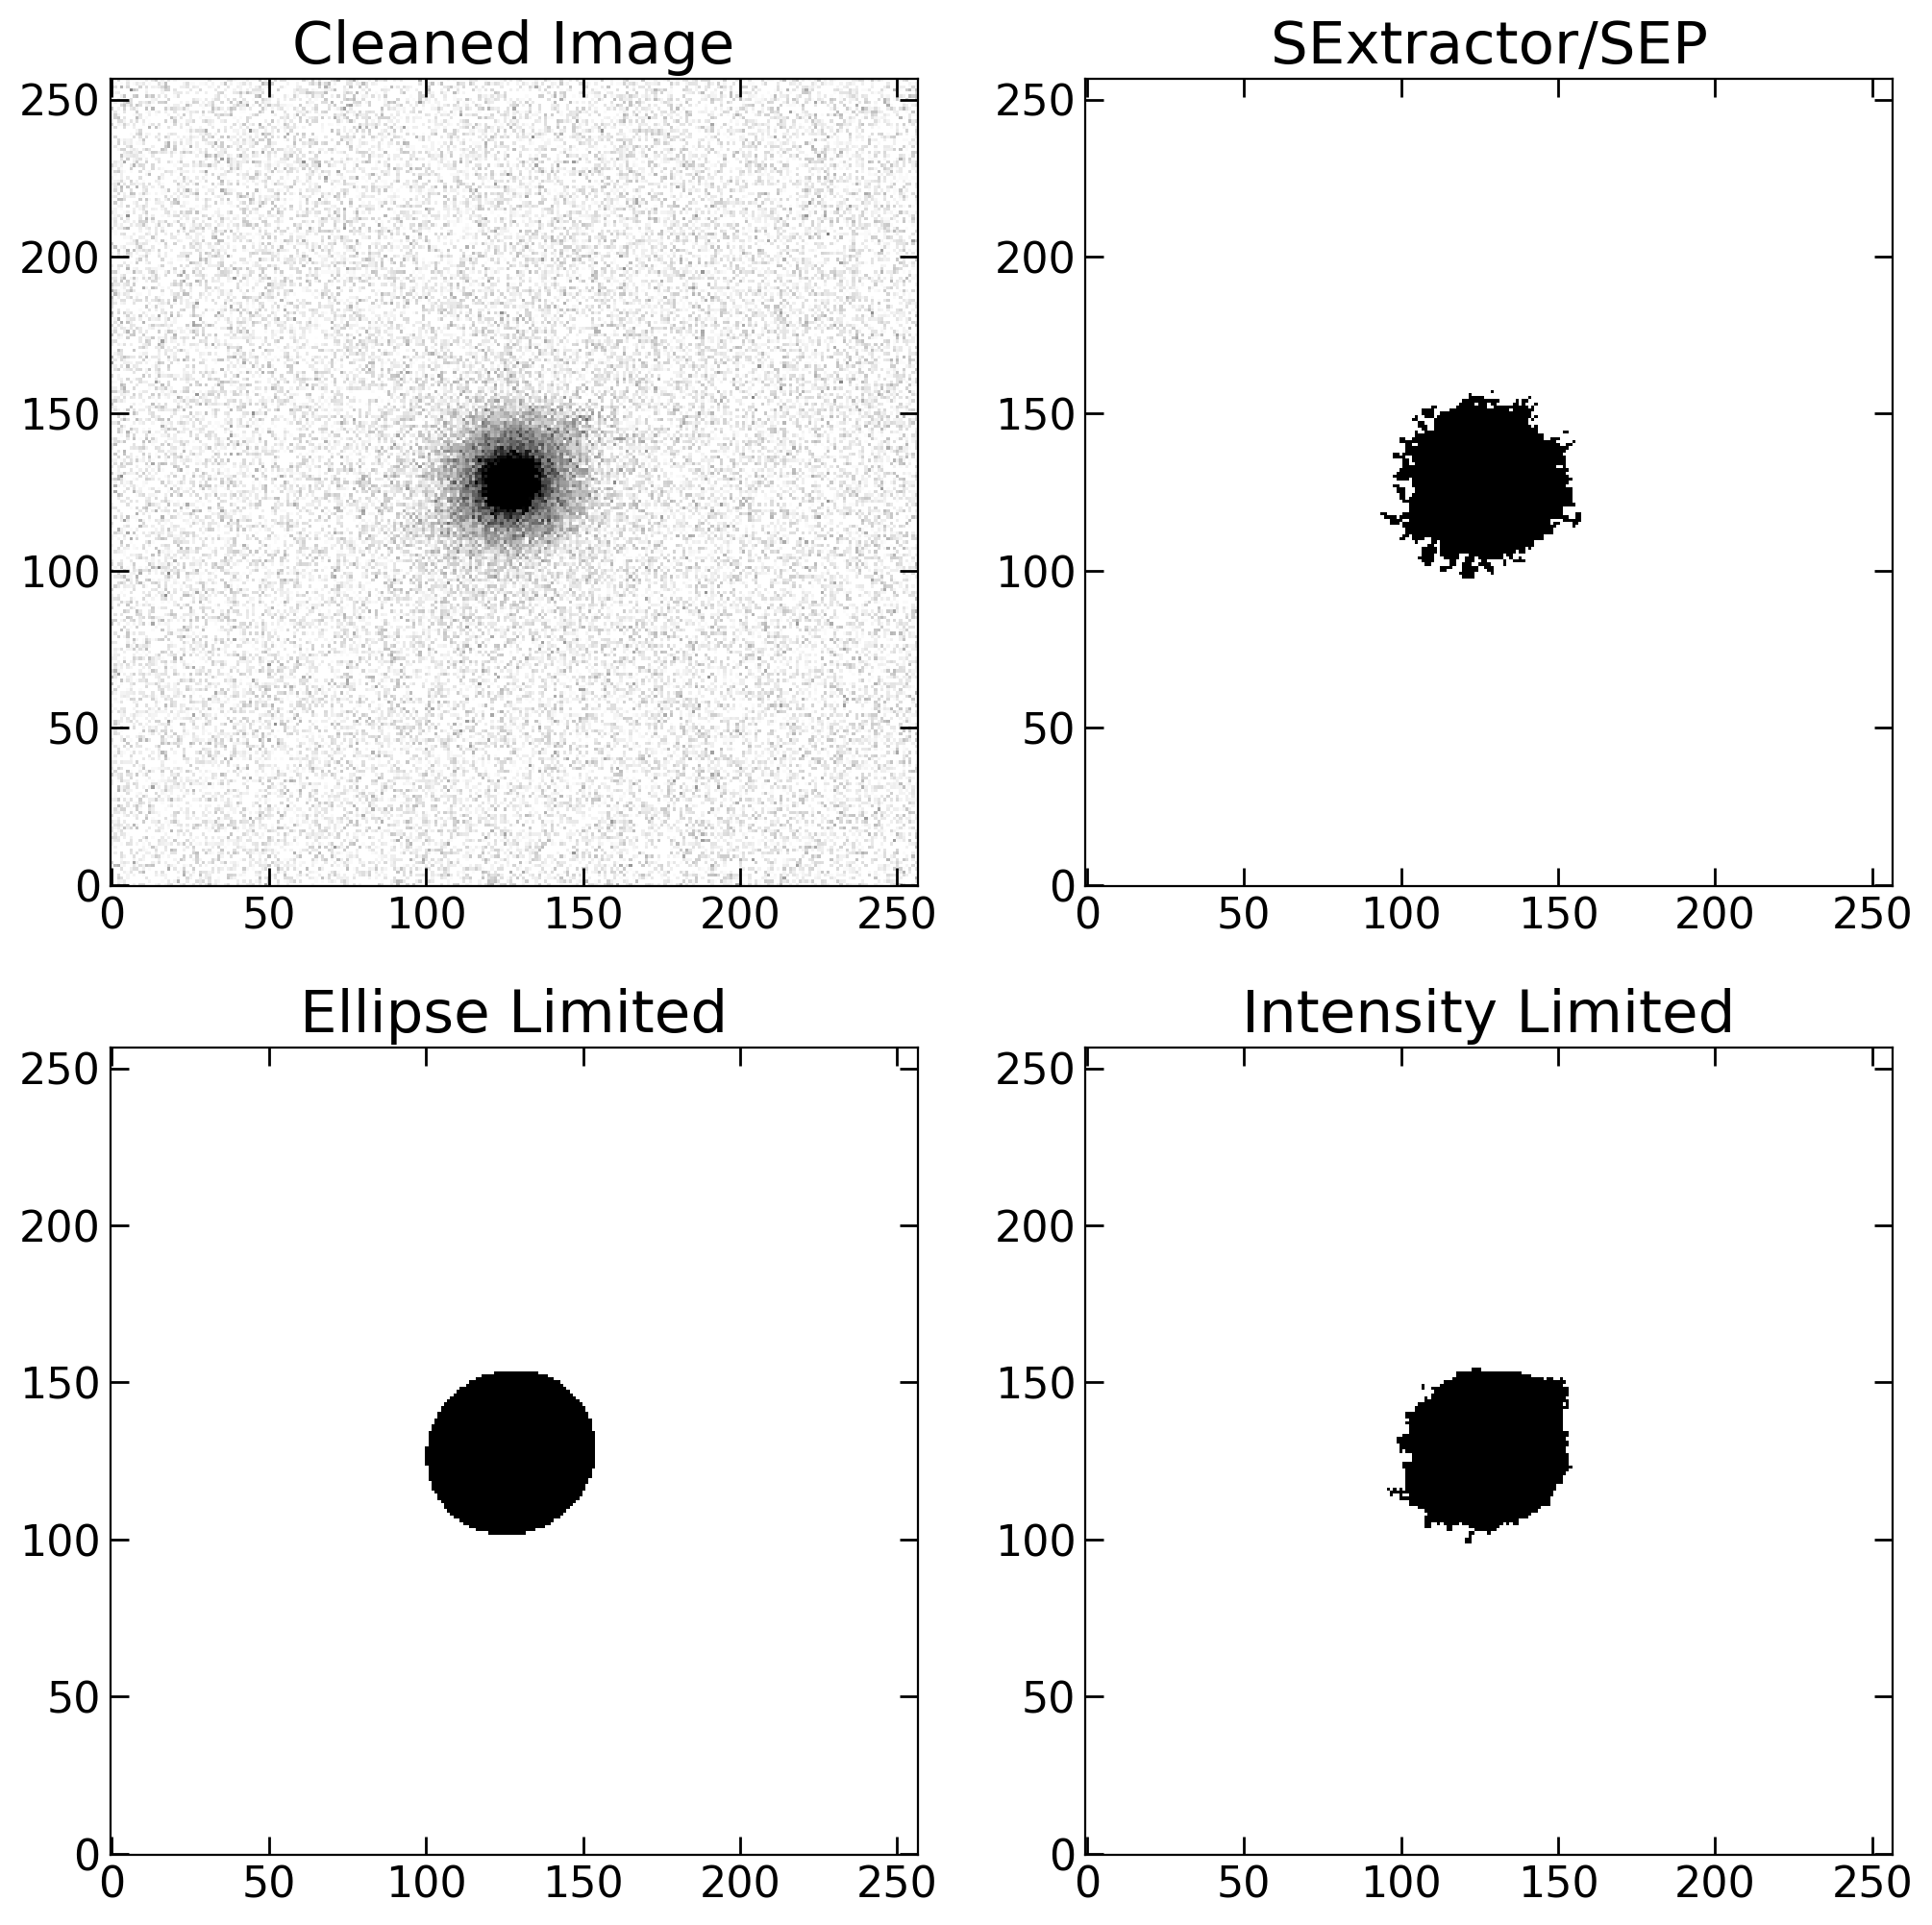

In [32]:
plt.figure(figsize  = (12,12), dpi = 200)

plt.subplot(2,2,1)
plt.title('Cleaned Image', fontsize = 22)
plt.imshow(galaxy_clean_iso, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,2)
plt.title('SExtractor/SEP', fontsize = 22)
plt.imshow(segmentation_original, origin = 'lower', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,3)
plt.title('Ellipse Limited', fontsize = 22)
plt.imshow(segmentation_ellipse, origin = 'lower', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(2,2,4)
plt.title('Intensity Limited', fontsize = 22)
plt.imshow(segmentation_intensity, origin = 'lower', vmax = 1, vmin = 0, cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)
#plt.savefig('output_images/segmentation_comparison.pdf', bbox_inches = 'tight')

# Generating a noise map

In some metrics, besides galaxy measurements, it is also required some noise correction. The package contain a pre-defined function to create "mini" version of the images such that the three required images (galaxy, noise, and segmentation mask) is easily retrieved.

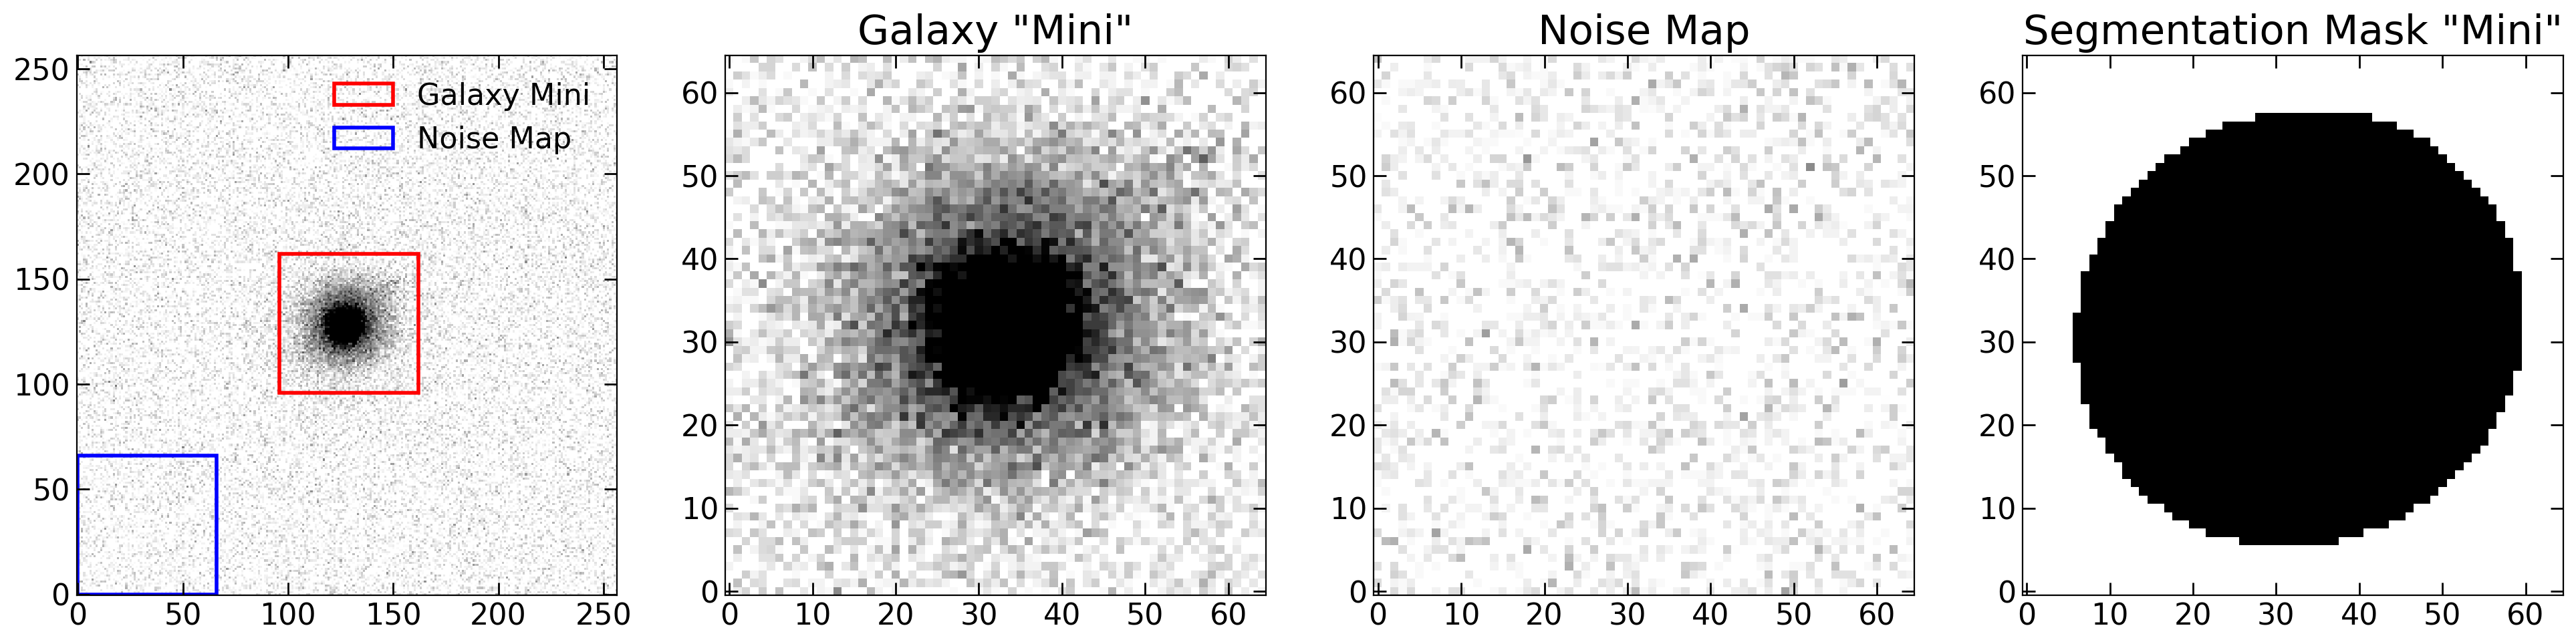

In [33]:
from galmex.Utils_module import extract_cutouts

clean_mini, segmented_mini, ranges, noise_mini, best_corner = extract_cutouts(galaxy_clean_iso, segmentation_ellipse, expansion_factor=1.2, estimate_noise=True)


plt.figure(figsize = (24,6), dpi = 200)

# Define the rectangle coordinates for galaxy_mini and noise_mini
plt.subplot(1,4,1)
m, s = np.nanmedian(galaxy_clean_iso), np.nanstd(galaxy_clean_iso)
plt.imshow(galaxy_clean_iso, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')

delta = (ranges[1]-ranges[0])/2
x0,y0 = len(galaxy_clean_iso[0])/2, len(galaxy_clean_iso)/2
galaxy_rect = [x0 - delta, x0 + delta + 1, y0 - delta, y0 + delta + 1]
noise_rect = [0, 2 * delta + 1, 0, 2 * delta + 1]
# Add a red rectangle for galaxy_mini
plt.gca().add_patch(plt.Rectangle((galaxy_rect[0], galaxy_rect[2]),
                                   galaxy_rect[1] - galaxy_rect[0],
                                   galaxy_rect[3] - galaxy_rect[2],
                                   edgecolor="red", facecolor="none", linewidth=2, label="Galaxy Mini"))

# Add a blue rectangle for noise_mini
plt.gca().add_patch(plt.Rectangle((noise_rect[0], noise_rect[2]),
                                   noise_rect[1] - noise_rect[0],
                                   noise_rect[3] - noise_rect[2],
                                   edgecolor="blue", facecolor="none", linewidth=2, label="Noise Map"))
plt.legend(frameon = False, fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)


plt.subplot(1,4,2)
plt.title('Galaxy "Mini"', fontsize = 22)
m, s = np.nanmedian(galaxy_clean_iso), np.nanstd(galaxy_clean_iso)
plt.imshow(clean_mini, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(1,4,3)
plt.title('Noise Map', fontsize = 22)
plt.imshow(noise_mini, origin = 'lower', vmin = m, vmax = m+(3*s), cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

plt.subplot(1,4,4)
plt.title('Segmentation Mask "Mini"', fontsize = 22)
plt.imshow(segmented_mini, origin = 'lower', vmin = 0, vmax = 1, cmap = 'gray_r')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.tick_params(direction = 'in', size = 7, left = True, right = True, bottom = True, top = True, 
                color = 'k', width = 1)

#plt.savefig('output_images/noise_map.pdf', bbox_inches = 'tight')

# Concentration

Concentration is one of the metrics from the CAS systems. It can be mathematically shown that it has a relation with the Sérsic index. Just as in the previous case, concentration is a class within the package, which requires only the full image as first input.

In [34]:
from galmex.Metrics_module import Concentration

conc = Concentration(galaxy_clean_iso, x, y, a ,b, theta)

## Following Conselice (2003)

The C parameter in Conselice is defined as $C = 5 \times \log(R_{20}/R_{80})$, where $R_{20}, R_{80}$ are the radii containing 20 and 80% of the total flux. Defining these radii depends on sampling the light profile of the object. It can be easily done by calling the "get_concentration" function implemented within the Concentration class. It requires object central coordinates (x, y), the best fitting ellipse parameters (a, b, and theta -- which are used for defining the apertures), and the method ("conselice" or "ferrari"). Notably, the total flux also must be calculated within a given aperture, for which the rmax (a semi-major axis, actually) defines the aperture containing the whole galaxy. In a more fine-grain tuning, the values of 20 and 80% are somewhat arbitrary, and both can be easily adapted by using the f_inner and f_outter args. Finally, sampling_step, Naround, and interp_order defined parameters of the sampling. In particular interp_order defines the interpolation order to get the exact radius value corresponding to the flux percentages.

In [35]:
C, rinner, routter = conc.get_concentration(method = 'conselice', 
                                            f_inner = 0.2, 
                                            f_outter = 0.8,
                                            rmax = 2*rp, 
                                            sampling_step = 0.5, 
                                            Naround = 3, 
                                            interp_order = 3)
print(C, rinner, routter)

4.224222120881006 3.496785 24.463205


## Following Barchi et al. (2020)

Similar to Conselice, the Concentration prescription presented in Ferrari et al.(2015) and Barchi et al.(2020) excludes the multiplicative factor: $C = \log(R_{20}/R_{80})$. It can be calculated using the same function as the above, only changing the method to "barchi".

In [36]:
C, rinner, routter = conc.get_concentration(method = 'ferrari', 
                                            f_inner = 0.2, 
                                            f_outter = 0.8,
                                            rmax = 2*rp, 
                                            sampling_step = 0.5, 
                                            Naround = 3, 
                                            interp_order = 3)
print(C, rinner, routter)

0.8448444241762012 3.496785 24.463205


## Calculate the growth curve

The Concentration involves the growth curve. For testing reliability and the stand-alone function"get_growth_curve" can be used to get the object's growth curve.

In [37]:
radii, growth_curve, growth_err = conc.get_growth_curve(rmax = 2*rp)

## Get radius containing a fraction of total flux

Based on above quantities, it is also possible to get the radius containing a given flux fraction using the in-built function "get_radius", it only receives the radii and growth curve arrays as input, alongside the fraction to define the radius. For instance, 0.5 means $R_{50}$.

In [38]:
r_half = conc.get_radius(fraction=0.5)

## Plotting utility

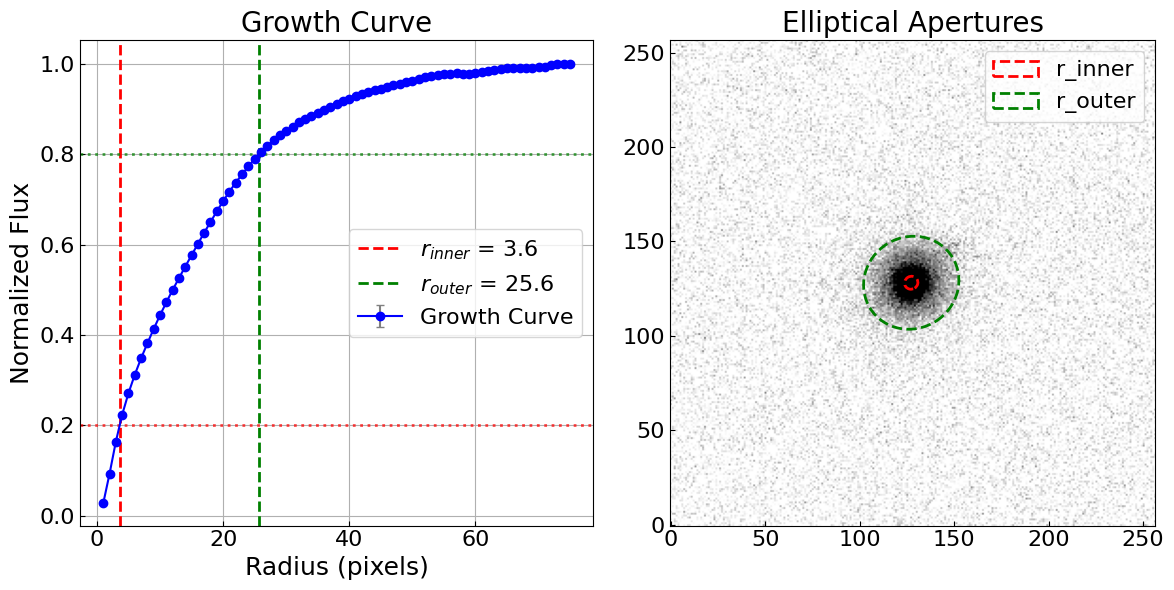

In [39]:
conc.plot_full_concentration()
#plt.savefig("concentration_example.pdf", bbox_inches = "tight")

# Asymmetry

Asymmetry is one of the indexes mainly used in the literature to define possible merger candidates. It is calculated by comparing the galaxy with its rotated (by an angle $\theta$ version. Similar to Concentration, in the GalMEx code it has its own dedicated class. The inputs are the galaxy image, the angle (in degrees, usually 180), the segmentation mask and the noise image. All must have the same dimensions. Besides, noise is optional, if it is not provided, then the values won't be corrected due to the noise.

In [40]:
from galmex.Metrics_module import Asymmetry

# Initialize the Asymmetry class
asymmetry_calculator = Asymmetry(clean_mini, angle=180, segmentation=segmented_mini, noise=noise_mini)


## Conselice's asymmetry
In Conselice (2000), two different ways of calculating asymmetry are compared. First the RMS, which is calculated as $ A^{2}_{\rm RMS} = \frac{\sum (I_{\rm o} - I_{\rm R})^{2}}{2 \times \sum I_{\rm o}^{2}}$. The second, ABS, is calculated as $ A_{\rm ABS} = \frac{\sum |I_{\rm o} - I_{\rm R}|}{2 \times \sum |I_{\rm o}|}$. The summation is done over all galaxy pixels. Since it depends on rotation, it may be extremely sensitive to central coordinates choice. Thus, a minimization process is applied to ensure that the value is the minimum for the galaxy, $A_{\text{RMS or ABS}}^{\rm Galaxy} = min(A_{\text{RMS or ABS}})$. This is done by computing asymmetry in a 3x3 grid until the central element being the minimum. The "max_iter" parameter defines the number of allowed iterations in this procedure. If a noise map is provided, the same procedure (including minimization) is done to account for the noise influence,  $A^{\rm Noise}_{\rm ABS} = \frac{\sum |N_{\rm o} - N_{\rm R}|}{2 \times \sum |I_{\rm o}|}$, such that the final asymmetry is given by $A_{\rm final} = min(A^{\rm Galaxy}) - min(A^{\rm Noise})$. The built function returns $A_{\rm final}, A^{\rm Galaxy}, \, {\rm and} \, A_{\rm noise}$, in addition to the center used for the galaxy and for the noise, and the number of iterations to reach each. 

*****An important caveat is how the comparison between pixels is done. Since the comparison between original and rotated images, both limited to a segmentation mask, not necessarily a pixel from the original image will have a correspondent valid pixel in the rotated image. Thus, it is necessary to make a choice on the criteria that these pixels are considered. For instance, in $Statmorph$ it requirer only one valid value (i.e. non-zero in the original OR in the rotated) to take the pixel into account. A more strict version may require both to be valid (i.e. non-zero in the original AND in the rotated). These different methods can be controlled via the "pixel_comparison" parameter, such that "equal" is equivalent to "AND", and "simple" is equivalent to "OR".}

In [41]:
A_final, A_gal, A_noise, center_gal, center_noise, niter_gal, niter_noise = asymmetry_calculator.get_conselice_asymmetry(method='absolute', 
                                                                                                                         pixel_comparison='equal', 
                                                                                                                         max_iter=50)
print(A_final, A_gal, A_noise, niter_gal, niter_noise, center_gal)

0.0761868219951819 0.13637870392432128 0.06019188192913938 2 8 (np.int64(33), np.int64(34))


## Ferrari's asymmetry

Differently from the previous one, the Asymmetry presented in Ferrari et al.(2015) and Barchi et al.(2020) uses the correlation coefficient to define the asymmetry, $A = 1 - r$, where r is the spearman or the pearson (selected via corr_type parameter in the function call) correlation coefficients. In this case, there is no noise term, but the minimization is done following the same procedure as the applied for the case above. The function returns the asymmetry value, the maximum correlation coefficient, the center coordinates and the number of iterations needed to reach the minimum.

In [42]:
A_barchi, r_max, center, niter = asymmetry_calculator.get_ferrari_asymmetry(corr_type='spearman', 
                                                                            pixel_comparison='equal', 
                                                                            max_iter=50)  
print(A_barchi, r_max, niter)

0.18764247448009264 0.8123575255199074 2


## Sampaio's asymmetry
This is a version that I've been working on as a better alternative in comparison to Conselice's asymmetry. The idea is to get rid of the summation in both numerator and denominator, and, instead to compute the differences relative to the original pixel value. It is also has two options "RMS" and "ABS". In the case of ABS, it is given by $ A^{\rm Galaxy}_{ABS} = (1/N_{\rm pixels}) \times \left (\sum \frac{|I_{\rm O} - I_{\rm R}|}{|I_{\rm O}|} \right)$. In this case, the comparison is indeed done pixel-by-pixel and not summing up all the valid pixels as in the original formula. Similar to the original case, the minimization and noise terms are also computed. The final asymmetry value is given by: $A_{\rm final} = min((1/N_{\rm pixels}) \times \left (\sum \frac{|I_{\rm O} - I_{\rm R}|}{|I_{\rm O}|} \right)) - min((1/N_{\rm pixels}) \times \left (\sum \frac{|N_{\rm O} - N_{\rm R}|}{|I_{\rm O}|} \right))$. Similar to the original case, the pixel_comparison can be both "equal" or "simple".

In [43]:
A_final, A_gal, A_noise, center_gal, center_noise, niter_gal, niter_noise = asymmetry_calculator.get_sampaio_asymmetry(method='absolute', 
                                                                                                                       pixel_comparison='equal', 
                                                                                                                       max_iter=50)
print(A_final, A_gal, A_noise, niter_gal, niter_noise)

0.09053260748435221 0.3014951794321782 0.21096257194782597 2 3


## Plotting utility

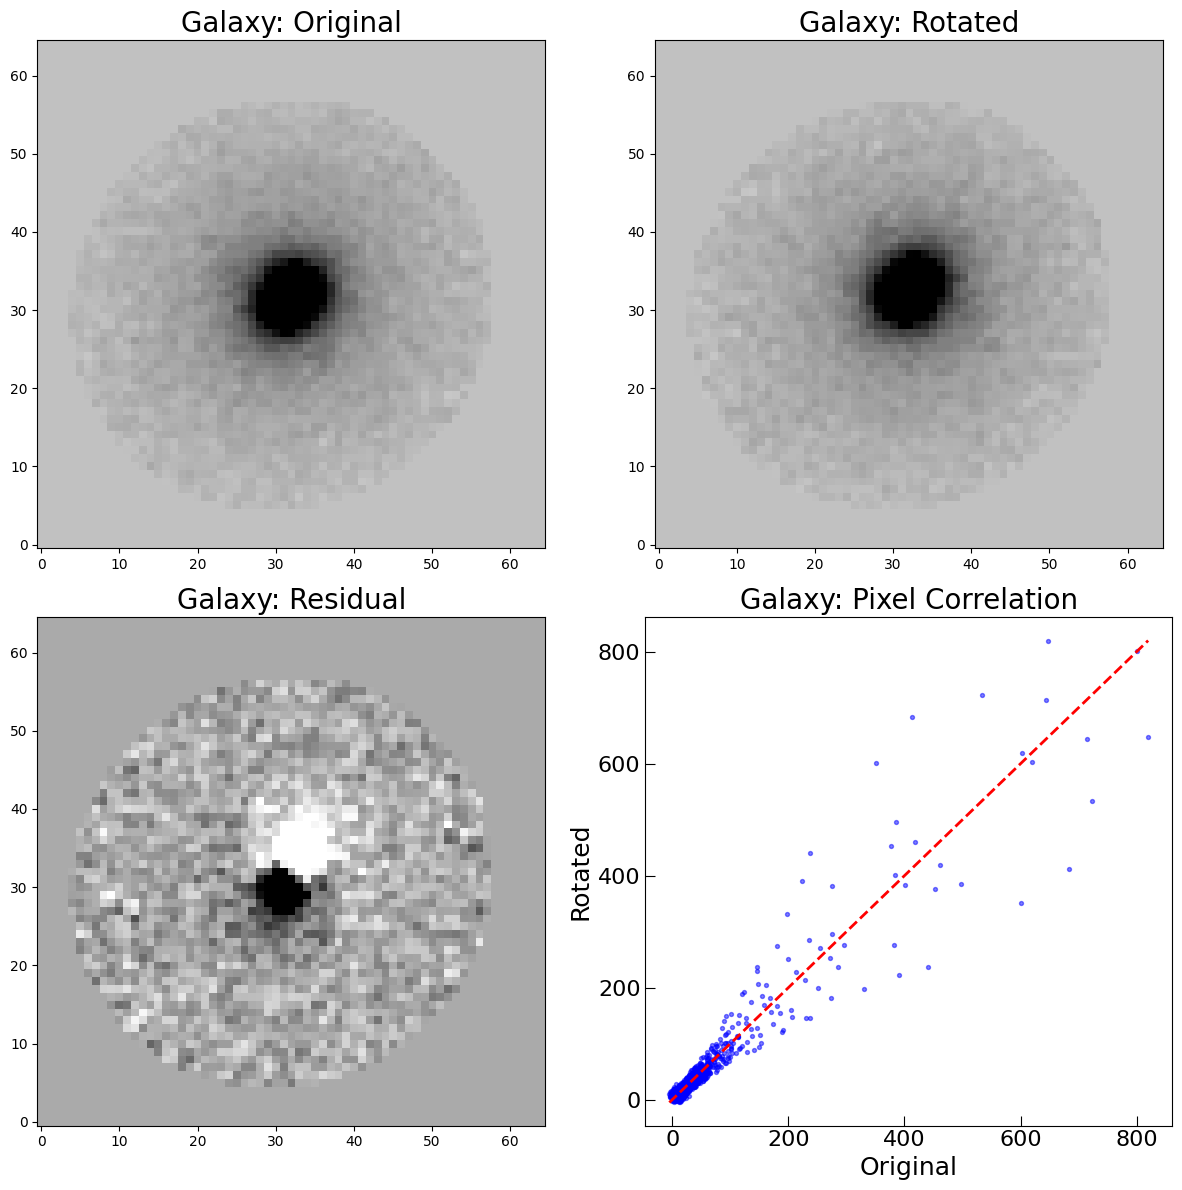

In [44]:
asymmetry_calculator.plot_asymmetry_diagnostics(method = "conselice")
#plt.savefig("asymmetry_example.pdf", bbox_inches = "tight")

# Smoothness

In [45]:
from galmex.Metrics_module import Smoothness

# Initialize the Smoothness class
smoothness_calculator = Smoothness(clean_mini, 
                                   segmentation=segmented_mini, 
                                   noise=noise_mini, 
                                   smoothing_factor=rp/5, 
                                   smoothing_filter="box")


## Conselice's Smoothness

In [46]:
S_final = smoothness_calculator.get_smoothness_conselice()
                
print(S_final)

1.4150104522705078


## Barchi's smoothness

In [47]:
S_final, r = smoothness_calculator.get_smoothness_ferrari()
print(S_final, r)

0.13386227491482294 0.8661377250851771


## Sampaio's smoothness

In [48]:
S_final, S_gal, S_noise = smoothness_calculator.get_smoothness_sampaio()
print(S_final, S_gal, S_noise)

0.050801635 0.28212416 0.23132253


## Plotting utilities

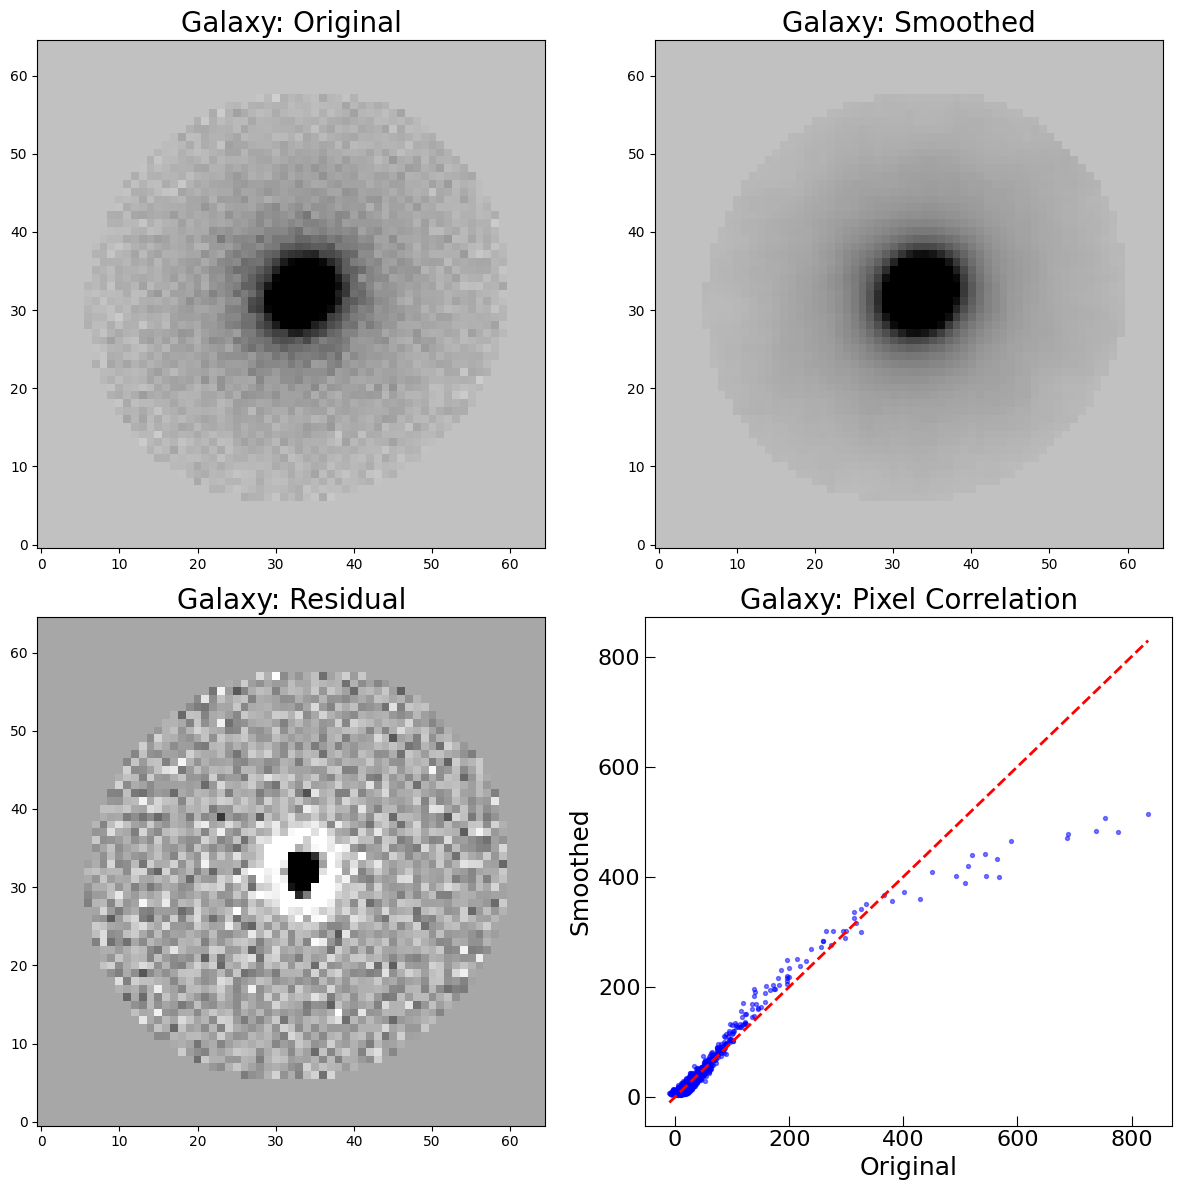

In [57]:
smoothness_calculator.plot_smoothness_diagnostics()
#plt.savefig("smoothness_example.pdf", bbox_inches = "tight")

# Moment of Light

In [58]:
from galmex.Metrics_module import Moment_of_light
moment_calculator = Moment_of_light(clean_mini, segmentation=segmented_mini)


## Calculate Mf (usually M20, f = 0.2)

In [59]:
m20, xc_m20, yc_m20 = moment_calculator.get_m20(f=0.2, minimize_total = True)


## Plotting facility

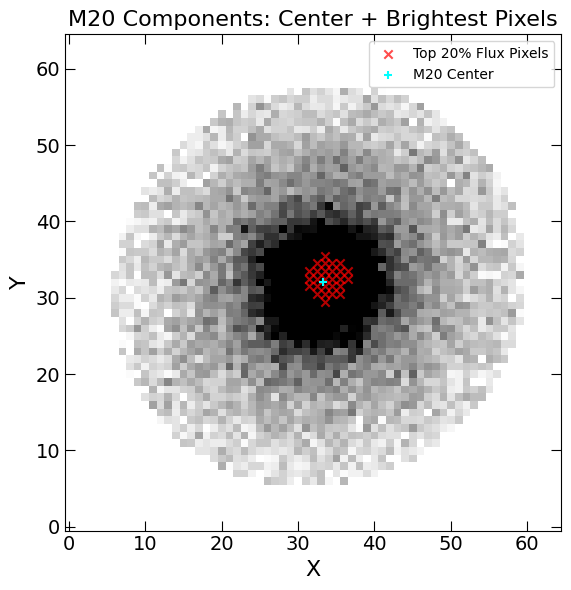

In [60]:
moment_calculator.plot_M20_contributors()
#plt.savefig("m20_example.pdf", bbox_inches = "tight")

# Shannon Entropy


In [56]:
from galmex.Metrics_module import Shannon_entropy

# Initialize the Shannon_entropy class
entropy_calculator = Shannon_entropy(clean_mini, segmentation=segmented_mini)


## Calculate entropy

In [62]:
entropy = entropy_calculator.get_entropy(normalize=True, nbins=100)
print(entropy)

0.4575725127344326


## Plotting utility

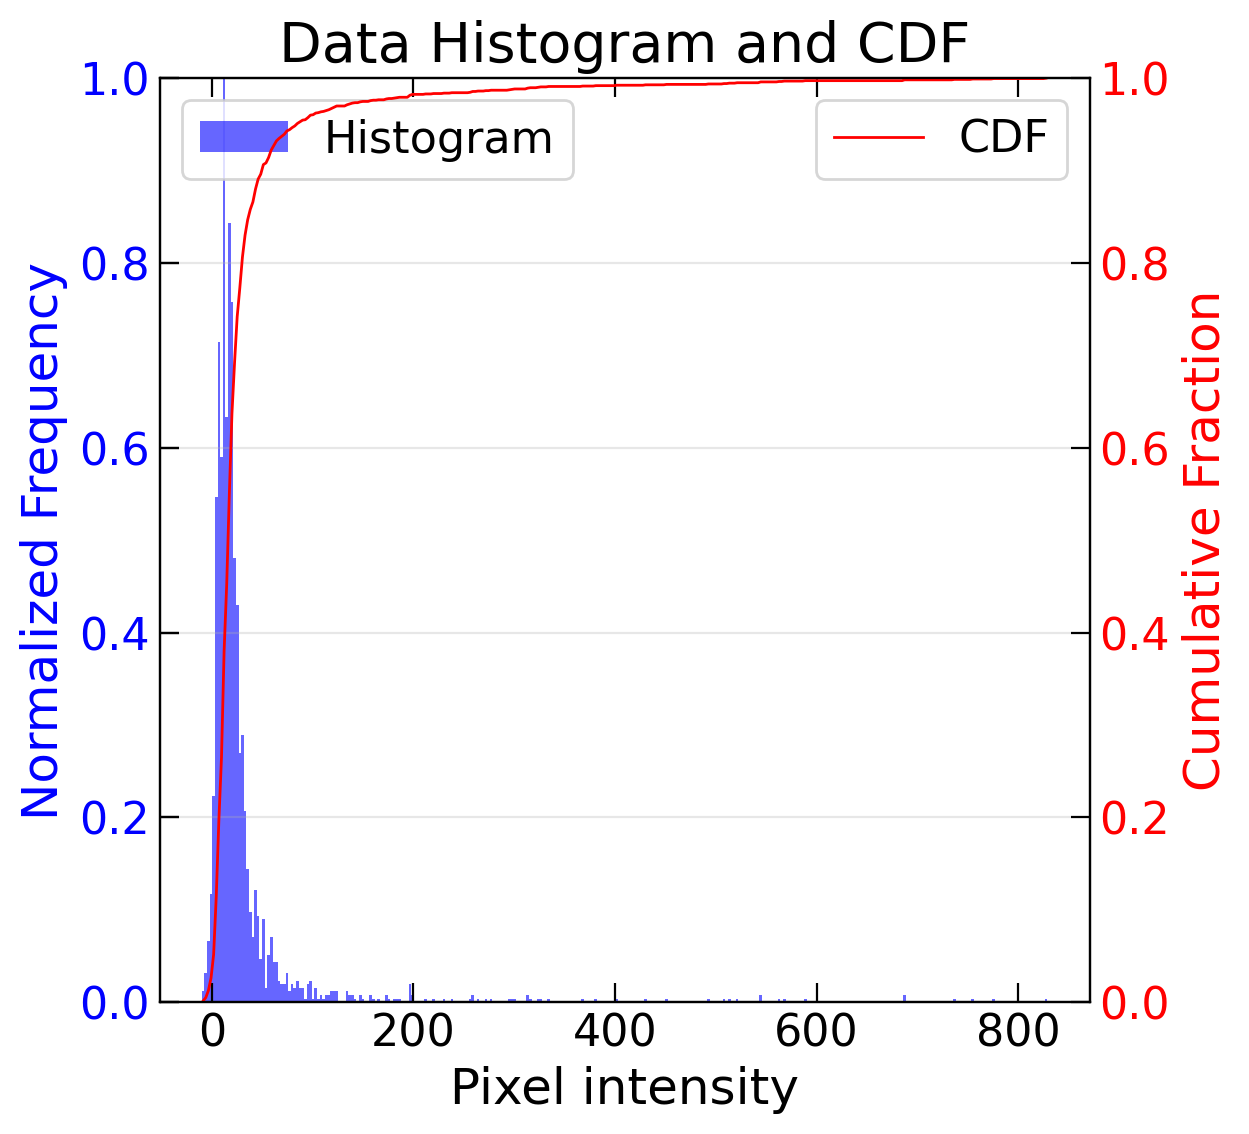

In [66]:
entropy_calculator.plot_entropy_frame()
#plt.savefig("entropy_example.pdf")

# Gini index

In [67]:
from galmex.Metrics_module import Gini_index

# Initialize the Gini_index class
gini_calculator = Gini_index(clean_mini, segmentation=segmented_mini)


## Calculate Gini index

In [68]:
gini = gini_calculator.get_gini()
print(gini)

0.5749693


## Get Lorentz curve

In [69]:
cumulative_pixels, cumulative_light = gini_calculator.compute_lorentz_curve()


## Visualization plot

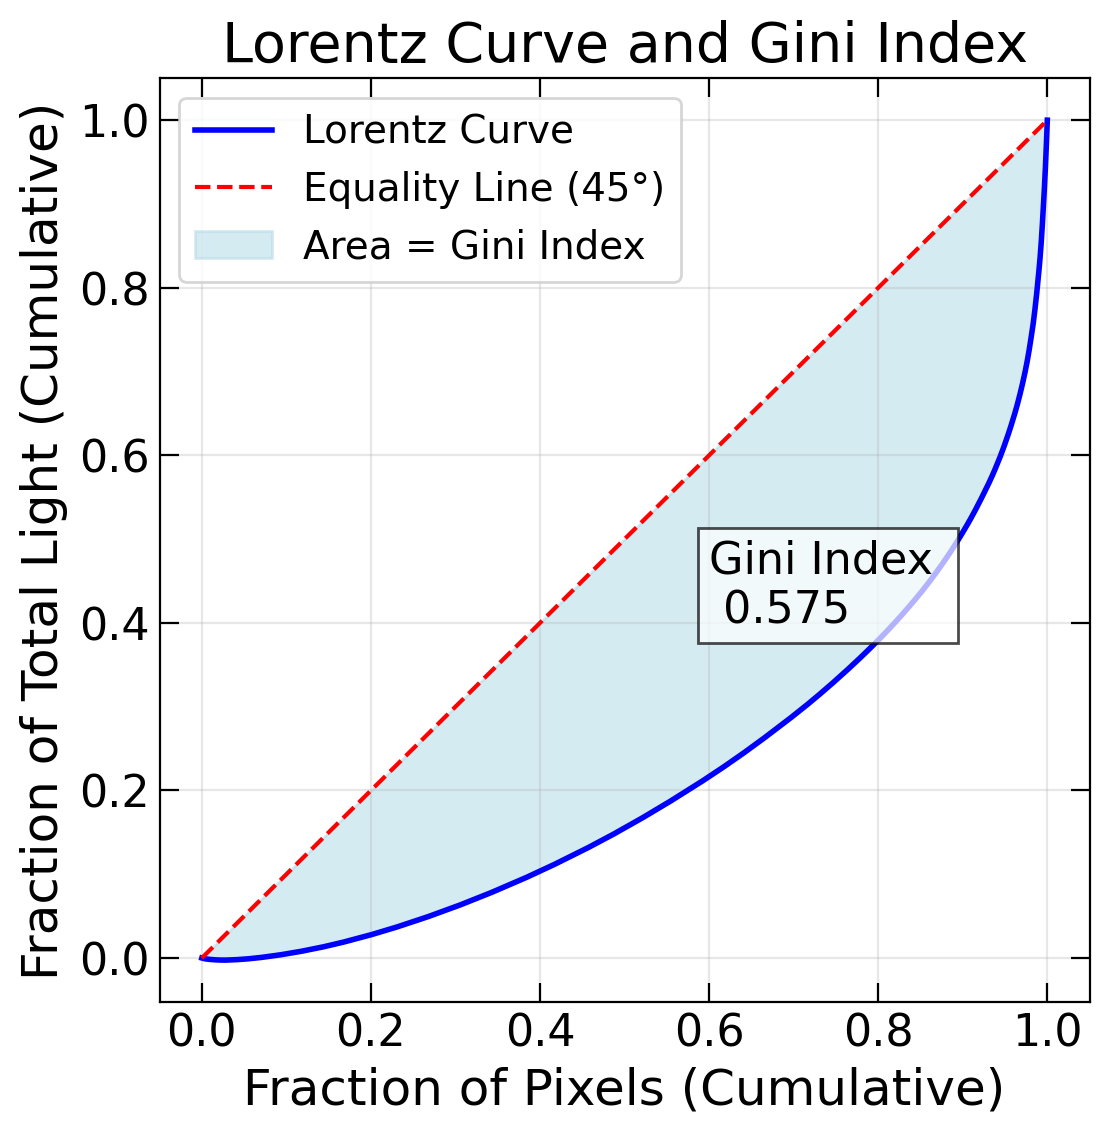

In [71]:
gini_calculator.plot_gini_rep()
#plt.savefig("gini_example.pdf")

# Gradient Pattern Analysis

In [54]:
from galmex.Metrics_module import GPA

# Initialize the GPA class
gpa = GPA(image=clean_mini, segmentation=segmented_mini)


## Asymmetry of the gradient field

In [55]:
# Calculate G2 parameter
g2 = gpa.get_g2(mtol=0.06, ptol=160)
print(g2)

0.1487756
